<a href="https://colab.research.google.com/github/frickajr/EnglishClassroomGaleShapleyOptimizationSingleList/blob/main/EnglishClassroomGaleShapleyOptimizationSingleListGit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
pip install networkx matplotlib

In [2]:
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

# Defs

## Calculates compatibility scores Defs

In [3]:
def euclidean_distance(row1, row2):
    """
    Calculates the Euclidean distance between two rows of a DataFrame.

    The Euclidean distance is the straight-line distance between two points
    in a multidimensional space, calculated as the square root of the sum
    of the squared differences between corresponding elements of the rows.

    Parameters:
    ----------
    row1 : pd.Series
        The first row for comparison, assumed to contain numerical data.

    row2 : pd.Series
        The second row for comparison, assumed to contain numerical data.

    Returns:
    -------
    float
        The Euclidean distance between the two rows.

    Notes:
    -----
    - The input rows must have the same index and length.
    - The rows are assumed to contain only numerical values.

    Example:
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> data = {'A': [1, 2], 'B': [2, 4], 'C': [3, 6]}
    >>> df = pd.DataFrame(data)
    >>> euclidean_distance(df.iloc[0], df.iloc[1])
    3.7416573867739413
    """

    # Convert the rows directly to NumPy arrays for efficient computation
    vec1 = row1.values
    vec2 = row2.values

    # Calculate and return the Euclidean distance using NumPy's linear algebra norm
    return np.linalg.norm(vec1 - vec2)


In [4]:
def compatibility_inverse_euclidean(row1, row2):
    """
    Calculates the inverse Euclidean distance between two rows of a DataFrame.

    The inverse Euclidean distance is a measure of similarity between two points,
    where smaller distances result in higher values (closer to 1), and larger
    distances result in smaller values (closer to 0).

    Parameters:
    ----------
    row1 : pd.Series
        The first row for comparison, assumed to contain numerical data.

    row2 : pd.Series
        The second row for comparison, assumed to contain numerical data.

    Returns:
    -------
    float
        The inverse Euclidean distance between the two rows, ranging between
        0 and 1, where a higher value indicates greater similarity.

    Notes:
    -----
    - The input rows must have the same index and length.
    - The rows are assumed to contain only numerical values.
    - The formula used is 1 / (1 + distance) to ensure that the inverse value
      is always between 0 and 1.

    Example:
    --------
    >>> import pandas as pd
    >>> data = {'A': [1, 2], 'B': [2, 4], 'C': [3, 6]}
    >>> df = pd.DataFrame(data)
    >>> compatibility_inverse_euclidean(df.iloc[0], df.iloc[1])
    0.21132486540518713
    """

    # Convert the rows directly to NumPy arrays for efficient computation
    vec1 = row1.values
    vec2 = row2.values

    # Calculate Euclidean distance using NumPy's linear algebra norm
    distance = np.linalg.norm(vec1 - vec2)

    # Return the inverse Euclidean distance, ensuring the value is between 0 and 1
    return 1 / (1 + distance)


In [5]:
def is_similar(value1, value2, threshold=0.1):
    """
    Determines if two values are similar based on a specified threshold.

    Parameters:
    ----------
    value1 : float
        The first value for comparison.

    value2 : float
        The second value for comparison.

    threshold : float, optional
        The maximum difference between the values for them to be considered similar.
        Default is 0.1.

    Returns:
    -------
    bool
        True if the values are similar within the threshold; False otherwise.

    Example:
    --------
    >>> is_similar(1.0, 1.05)
    True
    >>> is_similar(1.0, 1.2, threshold=0.1)
    False
    """
    return abs(value1 - value2) <= threshold


def jaccard_similarity(row1, row2, threshold=0.1):
    """
    Calculates the Jaccard similarity between two rows of a DataFrame based on a threshold for value similarity.

    The Jaccard similarity index is calculated as the size of the intersection divided by the size of the union of the row keys,
    with a condition on value similarity. If the values for the same key are considered similar (within the threshold),
    they contribute to the intersection.

    Parameters:
    ----------
    row1 : pd.Series
        The first row for comparison, assumed to contain numerical data.

    row2 : pd.Series
        The second row for comparison, assumed to contain numerical data.

    threshold : float, optional
        The threshold for considering values in the rows similar. Default is 0.1.

    Returns:
    -------
    float
        The Jaccard similarity index, a value between 0 (no similarity) and 1 (identical based on the threshold).

    Notes:
    -----
    - Both rows must have the same index, otherwise the result will be inaccurate.
    - The Jaccard similarity compares both the presence of keys and the similarity of the values.

    Example:
    --------
    >>> data = {'A': [1, 2], 'B': [2, 4], 'C': [3, 6]}
    >>> df = pd.DataFrame(data)
    >>> jaccard_similarity(df.iloc[0], df.iloc[1], threshold=0.2)
    0.6666666666666666
    """

    # Ensure both rows have the same keys
    if not row1.index.equals(row2.index):
        raise ValueError("The two rows must have the same index.")

    # Calculate the union and intersection based on key presence and value similarity
    union = len(row1)
    intersection = sum(is_similar(row1[key], row2[key], threshold) for key in row1.index)

    return intersection / union if union != 0 else 0


In [6]:
def cosine_similarity(row1, row2):
    """
    Calculates the cosine similarity between two rows of a DataFrame.

    Cosine similarity is a measure of similarity between two vectors
    of an inner product space. It is the cosine of the angle between
    the two vectors, and is computed as the dot product of the vectors
    divided by the product of their magnitudes (norms).

    Parameters:
    ----------
    row1 : pd.Series
        The first row for comparison, assumed to contain numerical data.

    row2 : pd.Series
        The second row for comparison, assumed to contain numerical data.

    Returns:
    -------
    float
        The cosine similarity, a value between -1 and 1.
        1 means the rows are identical, 0 means they are orthogonal,
        and -1 means they are opposite.

    Notes:
    -----
    - Both rows must have the same index.
    - If either vector is a zero vector (i.e., has a magnitude of zero),
      the result will be NaN since division by zero occurs.

    Example:
    --------
    >>> data = {'A': [1, 0], 'B': [0, 1], 'C': [1, 1]}
    >>> df = pd.DataFrame(data)
    >>> cosine_similarity(df.iloc[0], df.iloc[1])
    0.0
    >>> cosine_similarity(df.iloc[0], df.iloc[2])
    0.7071067811865475
    """

    # Ensure the rows have the same index
    if not row1.index.equals(row2.index):
        raise ValueError("The two rows must have the same index.")

    # Convert the rows directly to NumPy arrays for efficient computation
    vec1 = row1.values
    vec2 = row2.values

    # Compute the dot product of the two vectors
    dot_product = np.dot(vec1, vec2)

    # Compute the norms (magnitudes) of the vectors
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    # Avoid division by zero; if either norm is zero, return NaN
    if norm_vec1 == 0 or norm_vec2 == 0:
        return float('nan')

    # Return the cosine similarity
    return dot_product / (norm_vec1 * norm_vec2)


In [7]:
def compatibility_scores(df, type="Jaccard", normalize=False):
    """
    Calculates compatibility scores between all pairs of individuals in the DataFrame,
    with an option to normalize the scores, and preserving the IDs (which are assumed to be the DataFrame's index).

    Parameters:
    ----------
    df : pd.DataFrame
        A DataFrame where each row represents an individual's attributes, and the index represents IDs.

    type : str, optional
        The type of similarity measure to use. Options are "Jaccard", "Cosine",
        "InverseEuclideanDistance" (or "InverseEuclidean"), and "Euclidean".
        Default is "InverseEuclideanDistance".

    normalize : bool, optional
        If True, the compatibility scores will be normalized to the range [0, 1].
        Default is False.

    Returns:
    -------
    dict
        A dictionary with tuple keys representing pairs of individuals and their compatibility score as values.

    float
        The duration of the computation in seconds.

    Raises:
    -------
    ValueError
        If an unsupported similarity type is provided.

    Notes:
    ------
    - Normalization rescales the scores between 0 and 1, with 0 being the lowest similarity
      and 1 being the highest.
    - Assumes that the input DataFrame has numerical data only and that each row has the same structure.

    Example:
    --------
    >>> data = {'A': [1, 2, 3], 'B': [2, 3, 4], 'C': [3, 4, 5]}
    >>> df = pd.DataFrame(data)
    >>> scores, duration = compatibility_scores(df, type="Cosine", normalize=True)
    >>> print(scores)
    >>> print(f"Computation took {duration:.4f} seconds.")
    """

    # Check for valid similarity type
    valid_types = {"Jaccard", "Cosine", "InverseEuclidean", "Euclidean"}
    if type not in valid_types:
        raise ValueError(f"Unsupported similarity type '{type}'. Choose from {valid_types}.")

    # Record the start time
    start_time = time.time()

    # Initialize the dictionary to hold the compatibility scores
    compatibility_scores = {}

    # Iterate over all unique pairs of rows
    for i in range(len(df)):
        for j in range(i + 1, len(df)):  # Avoid recalculating (id_j, id_i)
            id_i = df.index[i]
            id_j = df.index[j]

            # Select the appropriate similarity measure
            if type == "Jaccard":
                score = jaccard_similarity(df.iloc[i], df.iloc[j])
            elif type == "Cosine":
                score = cosine_similarity(df.iloc[i], df.iloc[j])
            elif type == "InverseEuclidean":
                score = compatibility_inverse_euclidean(df.iloc[i], df.iloc[j])
            elif type == "Euclidean":
                score = euclidean_distance(df.iloc[i], df.iloc[j])

            # Store the score for both (id_i, id_j) and (id_j, id_i) as they are symmetric
            compatibility_scores[(id_i, id_j)] = score
            compatibility_scores[(id_j, id_i)] = score

    # Normalize the scores if requested
    if normalize and compatibility_scores:
        max_score = max(compatibility_scores.values())
        min_score = min(compatibility_scores.values())
        range_score = max_score - min_score
        if range_score > 0:
            compatibility_scores = {
                pair: (score - min_score) / range_score for pair, score in compatibility_scores.items()
            }
        else:
            # If all scores are the same, set them to 1.0 (as normalization isn't meaningful here)
            compatibility_scores = {pair: 1.0 for pair in compatibility_scores.keys()}

    # Calculate the time taken for the computation
    end_time = time.time()

    return compatibility_scores, (end_time - start_time)


In [8]:
def scores_to_matrix(scores, individual_ids):
    """
    Converts a dictionary of compatibility scores into a symmetric matrix.

    Parameters:
    ----------
    scores : dict
        A dictionary where keys are tuples of individual IDs (id_i, id_j) and values are the compatibility scores.

    individual_ids : list
        A list of individual IDs to determine the matrix size.

    Returns:
    -------
    numpy.ndarray
        A symmetric matrix of compatibility scores.

    Raises:
    -------
    ValueError
        If an individual ID in the scores dictionary is not found in individual_ids.

    Example:
    --------
    >>> scores = {('A', 'B'): 0.9, ('A', 'C'): 0.7, ('B', 'C'): 0.8}
    >>> individual_ids = ['A', 'B', 'C']
    >>> matrix = scores_to_matrix(scores, individual_ids)
    >>> print(matrix)
    array([[0. , 0.9, 0.7],
           [0.9, 0. , 0.8],
           [0.7, 0.8, 0. ]])
    """

    # Map individual IDs to matrix indices
    id_to_index = {id_: index for index, id_ in enumerate(individual_ids)}
    num_individuals = len(individual_ids)

    # Initialize a symmetric matrix with the default value
    matrix = np.zeros((num_individuals, num_individuals))


    for (id_i, id_j), score in scores.items():
        if id_i not in id_to_index or id_j not in id_to_index:
            raise ValueError(f"ID {id_i} or {id_j} not found in individual_ids.")

        # Get matrix indices
        i = id_to_index[id_i]
        j = id_to_index[id_j]

        # Assign scores symmetrically
        matrix[i, j] = score
        matrix[j, i] = score  # Ensure symmetry

    return matrix


## Matching Defs

In [9]:
def calculate_metrics(pairs, compatibility_scores, execution_time, iterations=0):
    """
    Calculates additional metrics for a set of paired individuals.

    Parameters:
    ----------
    pairs : dict
        A dictionary where keys are individual identifiers and values are the identifiers of their matched pair.

    compatibility_scores : dict
        A dictionary containing compatibility scores for each pair of individuals. Keys are tuples of individual IDs (id1, id2).

    execution_time : float
        The time taken to compute the pairing and compatibility scores.

    iterations : int, optional
        The number of iterations used in the computation, if applicable. Default is 0.

    Returns:
    -------
    dict
        A dictionary containing various metrics, including pair strengths, total and average compatibility,
        compatibility distribution among pairs, execution time, and iterations.

    Notes:
    -----
    - If a pair's compatibility score is not found, the score defaults to 0.
    - The `pairs` dictionary is assumed to only contain one direction of the pair (i.e., if A is paired with B, then only `A: B` is present).
    """
    # Calculate the strength of each pair
    pair_strength = {
        (person, pairs[person]): compatibility_scores.get((person, pairs[person]), 0)
        for person in pairs
    }

    # Calculate total compatibility and average compatibility
    total_compatibility = sum(pair_strength.values())
    average_compatibility = total_compatibility / len(pairs) if pairs else 0

    # List of compatibility scores for all pairs
    compatibility_distribution = list(pair_strength.values())

    return {
        "pairs": pairs,
        "pair_strength": pair_strength,
        "total_compatibility": total_compatibility,
        "average_compatibility": average_compatibility,
        "compatibility_distribution": compatibility_distribution,
        "execution_time": execution_time,
        "iterations": iterations
    }


In [10]:
def gale_shapley_matching(people, compatibility_scores):
    """
    Implements a modified version of the Gale-Shapley algorithm to find a stable matching within a single set of individuals based on their compatibility scores.
    This adaptation allows for the matching of individuals with each other from the same group, based on mutual preferences derived from compatibility scores.

    Parameters:
    ----------
    people : pd.DataFrame
        A DataFrame of individuals to be matched. Each individual is identified by their index in the DataFrame.

    compatibility_scores : dict
        A dictionary with tuple keys representing pairs of individuals and their compatibility score as values.

    Returns:
    -------
    dict
        A dictionary containing the resulting pairs, the strength of each pair, average compatibility,
        compatibility distribution, execution time, and the number of iterations performed.

    Raises:
    -------
    ValueError
        If any individual ID in the preferences list is not found in the compatibility scores.
    """
    start_time = time.time()

    ids = people.index.tolist()

    # Create preferences for each person based on sorted compatibility scores
    preferences = {
        id_: sorted(
            [other_id for other_id in ids if other_id != id_],
            key=lambda other_id: -compatibility_scores.get((id_, other_id), 0)
        )
        for id_ in ids
    }

    # Initialize empty pairs and free people
    pairs = {}
    free_people = set(ids)
    iterations = 0

    # Modified Gale-Shapley matching algorithm
    while free_people:
        iterations += 1
        person = free_people.pop()

        # Person proposes to their most preferred match who hasn't rejected them
        for preferred in preferences[person]:
            current_pair = pairs.get(preferred)

            # Check if the preferred person is unmatched or prefers the current proposal
            if current_pair is None or compatibility_scores.get((person, preferred), 0) > compatibility_scores.get((current_pair, preferred), 0):
                if current_pair:
                    free_people.add(current_pair)  # The current pair is now unmatched

                pairs[preferred] = person  # Form new pair
                break

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate metrics and return the result
    return calculate_metrics(pairs, compatibility_scores, execution_time, iterations)

In [11]:
def random_matching(people, compatibility_scores):
    """
    Performs random pairing among a list of individuals using numpy's random module. If the number of
    individuals is odd, one individual will remain unpaired and be noted in the results.

    Parameters:
    ----------
    people : pd.DataFrame
        A DataFrame of individuals to be paired. Each individual is identified by their index.

    compatibility_scores : dict
        A dictionary containing compatibility scores for each possible pair of individuals.

    Returns:
    -------
    dict
        A dictionary containing various metrics about the generated pairs, including pair strengths,
        average compatibility, compatibility distribution, execution time, and more, as calculated by
        the calculate_metrics function.

    Notes:
    -----
    - If there is an odd number of individuals, one person will remain unpaired.
    - The pairs are stored symmetrically, so both (A: B) and (B: A) are recorded.
    """
    start_time = time.time()

    ids = people.index.tolist()
    np.random.shuffle(ids)

    pairs = {}
    unpaired = None

    # Create pairs from shuffled individuals
    for i in range(0, len(ids) - 1, 2):
        pairs[ids[i]] = ids[i + 1]
        pairs[ids[i + 1]] = ids[i]

    # If there's an odd number of individuals, mark the last one as unpaired
    if len(ids) % 2 == 1:
        unpaired = ids[-1]

    end_time = time.time()
    execution_time = end_time - start_time

    # Calculate metrics for the generated pairs
    result = calculate_metrics(pairs, compatibility_scores, execution_time)

    # Add information about the unpaired individual if applicable
    if unpaired:
        result['unpaired'] = unpaired

    return result


In [12]:
def apply_matching_and_analyze(people_data, compatibility_scores, type_scores="Jaccard", seed=None):
    """
    Applies Gale-Shapley Modified matching algorithm to subsets of people data, analyzes outcomes,
    and prepares data for visualization. Also returns the matched pairs.

    Parameters:
    - people_data (pd.DataFrame): Dataset containing individuals' attributes for matching.
    - compatibility_scores (dict): Dictionary containing compatibility scores for pairs.
    - type_scores (str): Type of scoring system used (e.g., "InverseEuclidean").
    - seed (int, optional): Seed for random number generator to ensure reproducibility.

    Returns:
    - DataFrame: A DataFrame containing statistical metrics of matchings.
    - dict: A dictionary containing matched pairs for each subset size and matching type.
    - Function call: Calls `plot_comparison_boxplots` to visualize the distributions of compatibility scores.
    """
    if type_scores not in compatibility_scores:
        raise ValueError(f"Invalid type_scores '{type_scores}' provided. Available types: {list(compatibility_scores.keys())}")

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Shuffle the people data and split into two subsets
    shuffled_data = people_data.sample(frac=1, random_state=seed)
    mid_point = len(shuffled_data) // 2

    subset_rm = shuffled_data.iloc[:mid_point]
    subset_gs = shuffled_data.iloc[mid_point:]

    results = {}
    labels = []
    distributions = []
    all_pairs = {}

    # Apply modified Gale-Shapley matching
    gs_result = gale_shapley_matching(subset_gs, compatibility_scores[type_scores])
    results["ModifiedGaleShapley"] = gs_result
    labels.append("ModifiedGaleShapley")
    distributions.append(gs_result['compatibility_distribution'])
    all_pairs["ModifiedGaleShapley"] = gs_result['pairs']

    # Apply random matching
    rm_result = random_matching(subset_rm, compatibility_scores[type_scores])
    results["Random"] = rm_result
    labels.append("Random")
    distributions.append(rm_result['compatibility_distribution'])
    all_pairs["Random"] = rm_result['pairs']

    # Prepare the data for statistical analysis
    data = {}
    for label, result in results.items():
        compatibility_distribution = [value for value in result['compatibility_distribution'] if not np.isnan(value)]
        if compatibility_distribution:
            stats = np.percentile(compatibility_distribution, [0, 25, 50, 75, 100])
            data[label] = [
                len(result['pairs']),
                np.mean(compatibility_distribution),
                np.std(compatibility_distribution),
                stats[0],  # min
                stats[1],  # 25%
                stats[2],  # median
                stats[3],  # 75%
                stats[4],  # max
                result['execution_time'],
                result['iterations']
            ]
        else:
            data[label] = [len(result['pairs']), None, None, None, None, None, None, None, result['execution_time'], result['iterations']]

    df_stats = pd.DataFrame(data, index=["count", "mean", "std", "min", "25%", "median", "75%", "max", "execution_time", "iterations"]).T

    # Call the visualization function
    plot_comparison_boxplots(distributions, f'Compatibility Score Comparison - {type_scores}', 'Compatibility Score', labels)

    return df_stats, all_pairs


## Plots Defs

In [13]:
def plot_heatmap(matrix, title, cmap='Greys', annot=False):
    """
    Plots a heatmap for a given matrix of compatibility scores.

    Parameters:
    ----------
    matrix : numpy.ndarray
        The matrix of compatibility scores to visualize.

    title : str
        The title of the heatmap, typically indicating the method and whether it's normalized.

    x_labels : list, optional
        Labels for the x-axis, corresponding to columns of the matrix. Default is None.

    y_labels : list, optional
        Labels for the y-axis, corresponding to rows of the matrix. Default is None.

    cmap : str, optional
        The colormap to use for the heatmap. Default is 'Greys'.

    annot : bool, optional
        Whether to annotate the heatmap with the numerical values of the matrix. Default is False.

    Utilizes Seaborn and Matplotlib to generate the heatmap with specified aesthetic preferences.
    """
    if matrix.size == 0:
        raise ValueError("The matrix is empty. Please provide a valid matrix for visualization.")

    plt.figure(figsize=(8, 6))

    # Create the heatmap with optional labels and annotations
    sns.heatmap(matrix, cmap=cmap, annot=annot, fmt=".2f", linewidths=.5, cbar=True)

    # Add title and adjust layout
    plt.title(title, fontsize=14)
    plt.tight_layout()

    plt.show()


In [14]:
def plot_comparison_boxplots(data_to_plot, title, ylabel, xticklabels):
    """
    Plots a comparison of boxplots for multiple distributions of data.

    This function takes multiple distributions, cleans them by removing NaN values,
    and visualizes the data using boxplots. The boxplots are styled in black and white
    for a clean appearance. The function also allows customization of axis labels,
    title, and tick labels.

    Parameters:
    ----------
    data_to_plot : list of lists
        A list where each element is a list of numerical data representing one distribution.

    title : str
        The title of the boxplot chart.

    ylabel : str
        The label for the y-axis.

    xticklabels : list of str
        The labels for the x-axis, corresponding to each distribution.

    Raises:
    -------
    ValueError
        If the input list `data_to_plot` is empty.

    Notes:
    -----
    - NaN values in the distributions are automatically removed before plotting.
    - The box colors are dynamically assigned using different shades of grey.

    Example:
    --------
    >>> distributions = [[1, 2, 3], [2, 3, 4], [4, 5, 6]]
    >>> xticklabels = ["Dataset A", "Dataset B", "Dataset C"]
    >>> plot_comparison_boxplots(distributions, "Comparison of Datasets", "Values", xticklabels)
    """

    # Clean distributions to remove NaN values
    cleaned_distributions = []
    for distribution in data_to_plot:
        cleaned_distributions.append([value for value in distribution if not np.isnan(value)])

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Creating the boxplot with black and white colors only
    bp = ax.boxplot(cleaned_distributions, patch_artist=True,
                    boxprops=dict(linestyle='-', linewidth=2, color='black', facecolor='lightgrey'),
                    medianprops=dict(linestyle='-', linewidth=2, color='black'),
                    whiskerprops=dict(linestyle='-', linewidth=1.5, color='black'),
                    capprops=dict(linestyle='-', linewidth=1.5, color='black'),
                    flierprops=dict(marker='o', markerfacecolor='black', markersize=8, linestyle='none'))

    # Dynamically generate colors based on the number of distributions
    colors = plt.cm.Greys(np.linspace(0.3, 0.7, len(cleaned_distributions)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Setting the axis labels with appropriate font and size
    ax.set_title(title, fontname='serif', fontsize=18)
    ax.set_ylabel(ylabel, fontname='serif', fontsize=16)
    ax.set_xticklabels(xticklabels, fontname='serif', fontsize=16)

    # Ensure the axis ticks are readable
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Adding grid lines for better readability
    ax.grid(True, linestyle='--', color='black', linewidth=1, alpha=0.7)

    # Set the axis line width and color
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    # Ensure layout is tight so labels/axes do not cut off when saving the figure
    plt.tight_layout()

    # Show plot for inspection
    plt.show()


In [15]:
def create_ordered_bipartite_graph_from_list(matched_pairs_list, title,
                                             node_color='lightgray',
                                             edge_color='gray',
                                             node_size=3000):
    """
    Creates and displays an ordered bipartite graph from a list of matched pairs.

    This function visualizes a bipartite graph where nodes represent individuals
    and edges connect matched pairs. The graph layout ensures that nodes from
    the same group are aligned, making the graph more readable.

    Parameters:
    ----------
    matched_pairs_list : list of tuples
        A list of tuples, where each tuple represents a matched pair of individuals.

    title : str
        The title of the graph, which will appear above the plot.

    node_color : str, optional
        The color for the nodes. Default is 'lightgray'.

    edge_color : str, optional
        The color for the edges. Default is 'gray'.

    node_size : int, optional
        The size of the nodes. Default is 3000.

    Raises:
    -------
    ValueError
        If `matched_pairs_list` is empty or not a list of tuples.

    Notes:
    -----
    - The nodes are separated into two groups using a bipartite layout. Each group is aligned
      vertically to enhance clarity.
    - The graph uses grayscale colors for nodes and edges by default, but they can be customized.

    Example:
    --------
    >>> matched_pairs = [('A', '1'), ('B', '2'), ('C', '3')]
    >>> create_ordered_bipartite_graph_from_list(matched_pairs, "Bipartite Matching Graph", node_color='lightblue', edge_color='black')
    """

    if not matched_pairs_list or not all(isinstance(pair, tuple) and len(pair) == 2 for pair in matched_pairs_list):
        raise ValueError("`matched_pairs_list` must be a list of tuples, where each tuple contains two elements.")

    # Create a new bipartite graph
    B = nx.Graph()

    # Add nodes and edges from the list of matched pairs
    for a, b in matched_pairs_list:
        B.add_node(f"{a}", bipartite=0)  # Add to group 0
        B.add_node(f"{b}", bipartite=1)  # Add to group 1
        B.add_edge(f"{a}", f"{b}")

    # Separate nodes into the two bipartite groups
    group_a = sorted([node for node in B.nodes if B.nodes[node]['bipartite'] == 0])
    group_b = sorted([node for node in B.nodes if B.nodes[node]['bipartite'] == 1])

    # Create a layout for bipartite graphs
    pos = nx.drawing.layout.bipartite_layout(B, group_a)

    # Set figure size and background color
    plt.figure(figsize=(8, 6))
    plt.gca().set_facecolor('whitesmoke')
    plt.gca().spines[['top', 'right', 'left', 'bottom']].set_visible(False)

    # Draw the bipartite graph with custom node and edge colors
    nx.draw(B, pos, with_labels=True, node_size=node_size,
            node_color=node_color, font_size=14,
            font_family='serif', edge_color=edge_color)

    # Set the title with a serif font
    plt.title(title, fontname='serif', fontsize=18, color='black')

    # Turn off the axis for a cleaner look
    plt.axis('off')
    plt.show()


In [16]:
def pairs_to_bipartite_graph(matched_pairs, title):
    """
    Converts matched pairs into a bipartite graph and visualizes it.

    This function takes a dictionary of matched pairs, removes duplicate pairs (assuming the pairs
    are symmetric), and visualizes the unique pairs as a bipartite graph.

    Parameters:
    ----------
    matched_pairs : dict
        A dictionary where keys are individuals (nodes) and values are the corresponding matched pairs (other nodes).

    title : str
        The title for the graph visualization.

    Raises:
    -------
    ValueError
        If `matched_pairs` is empty.

    Notes:
    -----
    - Duplicate pairs like (A, B) and (B, A) are removed to ensure that each pair is only represented once.
    - The function assumes that `create_ordered_bipartite_graph_from_list` is a helper function that visualizes the graph.

    Example:
    --------
    >>> matched_pairs = {'A': 'B', 'C': 'D', 'B': 'A', 'D': 'C'}
    >>> pairs_to_bipartite_graph(matched_pairs, "Matching Graph")
    """

    if not matched_pairs:
        raise ValueError("matched_pairs dictionary is empty. Please provide valid input.")

    # Use a set to track pairs and avoid duplicates
    unique_pairs = set()
    for key, value in matched_pairs.items():
        if (value, key) not in unique_pairs:
            unique_pairs.add((key, value))

    # Convert the set back to a list for visualization
    filtered_pairs = list(unique_pairs)

    # Visualize the unique pairs as a bipartite graph
    create_ordered_bipartite_graph_from_list(filtered_pairs, title)


In [17]:
def plot_comparison_boxplots_score(data_to_plot, title, ylabel, xticklabels, colors=[]):
    """
    Generates a box plot to compare the distributions of different score metrics.

    This function creates a boxplot for each dataset in `data_to_plot`, where each box plot
    can be color-coded using the `colors` parameter. The resulting plot is styled in black
    and white with grid lines and axis labels. If no custom colors are provided, all boxes
    will default to 'lightgrey'.

    Parameters:
    ----------
    data_to_plot : list of lists
        A list of lists, where each inner list contains the data for one box plot.

    title : str
        The title of the plot.

    ylabel : str
        The label for the y-axis.

    xticklabels : list of str
        The labels for the x-axis ticks, corresponding to the datasets in `data_to_plot`.

    colors : list of str, optional
        A list of colors for each box. If not provided or if the length of `colors` does
        not match the number of data lists, a default color ('lightgrey') will be applied
        to all boxes.

    Raises:
    -------
    ValueError
        If the length of `xticklabels` does not match the length of `data_to_plot`.

    Notes:
    -----
    - The function automatically adjusts the layout to ensure that axis labels are not cut off.
    - Customizable color input allows for better differentiation between datasets in the plot.

    Example:
    --------
    >>> data = [[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6]]
    >>> labels = ["Group 1", "Group 2", "Group 3"]
    >>> plot_comparison_boxplots_score(data, "Comparison of Scores", "Score", labels, colors=['lightblue', 'lightgreen', 'lightpink'])
    """

    # Validate the length of xticklabels
    if len(xticklabels) != len(data_to_plot):
        raise ValueError("The number of xticklabels must match the number of data distributions.")

    # If the number of colors does not match the number of datasets, default to 'lightgrey'
    if len(colors) != len(data_to_plot):
        colors = ['lightgrey'] * len(data_to_plot)

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Creating the boxplot with the provided colors
    bp = ax.boxplot(data_to_plot, patch_artist=True,
                    boxprops=dict(linestyle='-', linewidth=2, color='black'),
                    medianprops=dict(linestyle='-', linewidth=2, color='black'),
                    whiskerprops=dict(linestyle='-', linewidth=1.5, color='black'),
                    capprops=dict(linestyle='-', linewidth=1.5, color='black'),
                    flierprops=dict(marker='o', markerfacecolor='black', markersize=8, linestyle='none'))

    # Set the facecolor for each box
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Set the title, y-axis label, and x-axis tick labels
    ax.set_title(title, fontname='serif', fontsize=18)
    ax.set_ylabel(ylabel, fontname='serif', fontsize=16)
    ax.set_xticklabels(xticklabels, fontname='serif', fontsize=16)

    # Adjust tick parameters for readability
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', color='black', linewidth=1, alpha=0.7)

    # Customize the appearance of the plot's axis lines
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    # Automatically adjust the layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()


In [18]:
def plot_combined_violin_boxplot_vertical(df_all_metrics, x_plot, y_plot, title):
    """
    Plots a combined vertical violin and boxplot for visualizing distributions of a dataset.

    This function generates a violin plot overlaid with a boxplot to provide both density
    estimation and statistical summaries (e.g., medians and quartiles) for a given dataset.
    The plots are created in a vertical layout, with aesthetic adjustments for clarity and readability.

    Parameters:
    ----------
    df_all_metrics : pd.DataFrame
        The dataset containing the metrics to be plotted. It should have columns corresponding
        to the `x_plot` and `y_plot` arguments.

    x_plot : str
        The column name in `df_all_metrics` that will be used for the x-axis.

    y_plot : str
        The column name in `df_all_metrics` that will be used for the y-axis.

    title : str
        The title of the plot.

    Notes:
    -----
    - The violin plot provides a KDE (Kernel Density Estimate) visualization, showing the
      distribution of data points, while the boxplot overlays summary statistics such as
      quartiles and median.
    - The function avoids duplicating the legend by suppressing the hue-based legend in the violin plot.
    - Custom aesthetics include gridlines, serif fonts, and a tight layout to ensure proper
      display of elements when saving or viewing the plot.

    Example:
    --------
    >>> import pandas as pd
    >>> data = {'Category': ['A', 'A', 'B', 'B'], 'Values': [10, 12, 13, 11]}
    >>> df_all_metrics = pd.DataFrame(data)
    >>> plot_combined_violin_boxplot_vertical(df_all_metrics, 'Category', 'Values', 'Distribution of Values')

    """

    figsize = (8, 7)  # Adjusting figure size
    fig, ax = plt.subplots(figsize=figsize)

    # Creating the violin plot (vertical) with 'x_plot' as hue to prevent deprecation warning
    sns.violinplot(data=df_all_metrics, x=x_plot, y=y_plot,
                   hue=x_plot, palette=['lightgray', 'darkgray'], legend=False, ax=ax)

    # Overlaying the boxplot (vertical)
    sns.boxplot(data=df_all_metrics, x=x_plot, y=y_plot,
                whis=1.5, width=0.2, boxprops={'zorder': 2, 'facecolor': 'gray'},
                medianprops={'color': 'black'}, whiskerprops={'color': 'black'},
                capprops={'color': 'black'}, flierprops={'marker': 'o', 'color': 'black', 'markersize': 5},
                showfliers=True, ax=ax)

    # Aesthetic adjustments for the combined plot
    ax.set_title(title, fontname='serif', fontsize=18)
    ax.set_xlabel(x_plot, fontname='serif', fontsize=16)
    ax.set_ylabel(y_plot, fontname='serif', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Removing external lines for a cleaner look
    sns.despine(top=True, right=True, left=True)

    # Removing the legend to prevent duplicates
    ax.legend([], [], frameon=False)

    # Adding gridlines for improved readability
    ax.grid(True, linestyle='--', color='black', linewidth=1, alpha=0.7)

    # Adjusting plot borders
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    # Tight layout to prevent clipping of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [19]:
def plot_results(df_all_metrics, x_plot, y_plot, title):
    """
    Plots a violin plot of the metrics provided in a DataFrame, adjusting the figure size dynamically
    based on the number of unique categories in the y-axis.

    This function generates a vertical violin plot to visualize the distribution of metrics in a dataset,
    with customization for font styling and axis labels.

    Parameters:
    ----------
    df_all_metrics : pd.DataFrame
        The DataFrame containing the data to be plotted. It should contain the columns specified by `x_plot`
        and `y_plot`.

    x_plot : str
        The column name to be used for the x-axis.

    y_plot : str
        The column name to be used for the y-axis.

    title : str
        The title of the plot.

    Notes:
    -----
    - The height of the figure is adjusted dynamically based on the number of unique categories in `y_plot`.
    - The function uses a two-color palette ('lightgray' and 'darkgray') for the violin plots.
    - The inner distribution of the violin plot uses 'stick', which provides a visualization of individual
      datapoints.

    Example:
    --------
    >>> import pandas as pd
    >>> data = {'Category': ['A', 'A', 'B', 'B'], 'Values': [10, 12, 13, 11]}
    >>> df_all_metrics = pd.DataFrame(data)
    >>> plot_results(df_all_metrics, 'Values', 'Category', 'Distribution of Values')

    """
    figsize = (8, 2 * len(df_all_metrics[y_plot].unique()))  # Dynamically adjust the figure size
    plt.figure(figsize=figsize)

    # Create a violin plot with custom colors and inner stick representation
    sns.violinplot(df_all_metrics, x=x_plot, y=y_plot, hue=y_plot, inner='stick',
                   legend=False, palette=['lightgray', 'darkgray'])

    # Remove unnecessary plot borders
    sns.despine(top=True, right=True, bottom=True, left=True)

    # Set font styles for x-ticks, y-ticks, labels, and title
    plt.xticks(fontname='serif', fontsize=16)
    plt.yticks(fontname='serif', fontsize=16)
    plt.xlabel(x_plot, fontname='serif', fontsize=16)
    plt.ylabel(y_plot, fontname='serif', fontsize=16)
    plt.title(title, fontname='serif', fontsize=18)

    # Show the plot
    plt.show()


In [20]:
import matplotlib.pyplot as plt

def plot_pie(df, values_col, labels_col, title):
    """
    Plots a pie chart based on values and labels from a DataFrame.

    This function creates a pie chart using the values and labels provided in the specified
    columns of the DataFrame. The pie chart displays the proportion of each category.

    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to be plotted. It should have columns specified
        by `values_col` and `labels_col`.

    values_col : str
        The column name in `df` representing the values for the pie chart (e.g., percentages or counts).

    labels_col : str
        The column name in `df` representing the labels for each section of the pie chart.

    title : str
        The title of the pie chart.

    Example:
    --------
    >>> import pandas as pd
    >>> data = {'Category': ['A', 'B', 'C'], 'Values': [40, 30, 30]}
    >>> df = pd.DataFrame(data)
    >>> plot_pie(df, 'Values', 'Category', 'Category Distribution')
    """
    # Set figure size
    figsize = (8, 6)
    plt.figure(figsize=figsize)

    # Plot the pie chart
    plt.pie(df[values_col], labels=df[labels_col], autopct='%1.1f%%', colors=['lightgray', 'darkgray', 'lightblue'])

    # Set title with serif font
    plt.title(title, fontname='serif', fontsize=18)

    # Display the plot
    plt.show()


## Pair Metrics

In [21]:
def calculate_pair_metrics(pairs, df_performance):
    """
    Calculates performance metrics for pairs of individuals based on their individual performance data.

    This function computes the average, difference, and standard deviation of various performance metrics
    for each pair of individuals based on a provided DataFrame of performance data.

    Parameters:
    ----------
    pairs : dict
        A dictionary where the keys are individual identifiers (e.g., names or IDs), and the values are
        the identifiers of their corresponding matched pair.

    df_performance : pd.DataFrame
        A pandas DataFrame containing performance data for each individual, indexed by their identifier.
        Each column represents a performance metric, and the DataFrame must be indexed by individual IDs.

    Returns:
    -------
    dict
        A dictionary where each key is a pair identifier (formatted as "person-partner") and the value
        is another dictionary containing the following performance metrics for each feature in df_performance:
        - "avg_<column_name>": The average value for the pair.
        - "diff_<column_name>": The absolute difference between the two individuals.
        - "std_<column_name>": The standard deviation of the pair's values for the feature.

    Notes:
    -----
    - Non-numeric values or NaNs in the performance columns are coerced to NaN, and if any are found,
      a warning is printed, and the metric calculation is skipped for that pair and feature.
    - The 'user_name' column, if present, is ignored as it's assumed to be a non-numeric identifier.

    Example:
    --------
    >>> pairs = {'A': 'B', 'C': 'D'}
    >>> data = {'user_name': ['A', 'B', 'C', 'D'], 'performance1': [10, 12, 15, 14], 'performance2': [8, 9, 13, 12]}
    >>> df_performance = pd.DataFrame(data).set_index('user_name')
    >>> calculate_pair_metrics(pairs, df_performance)
    {
        'A-B': {
            'avg_performance1': 11.0,
            'diff_performance1': 2.0,
            'std_performance1': 1.0,
            'avg_performance2': 8.5,
            'diff_performance2': 1.0,
            'std_performance2': 0.5
        },
        'C-D': {
            'avg_performance1': 14.5,
            'diff_performance1': 1.0,
            'std_performance1': 0.5,
            'avg_performance2': 12.5,
            'diff_performance2': 1.0,
            'std_performance2': 0.5
        }
    }
    """

    pair_metrics = {}

    for person, partner in pairs.items():
        pair_key = f"{person}-{partner}"
        pair_metrics[pair_key] = {}

        for col in df_performance.columns:
            if col != 'user_name':  # Exclude 'user_name' if it's present
                # Convert values to numeric and handle non-numeric values
                person_value = pd.to_numeric(df_performance.loc[person, col], errors='coerce')
                partner_value = pd.to_numeric(df_performance.loc[partner, col], errors='coerce')

                # Skip metrics where either person's value is NaN
                if pd.isna(person_value) or pd.isna(partner_value):
                    print(f"Warning: Non-numeric or missing value encountered for {person} or {partner} in column {col}")
                    continue

                # Calculate metrics: average, absolute difference, and standard deviation
                pair_metrics[pair_key][f"avg_{col}"] = (person_value + partner_value) / 2
                pair_metrics[pair_key][f"diff_{col}"] = abs(person_value - partner_value)
                pair_metrics[pair_key][f"std_{col}"] = np.std([person_value, partner_value])

    return pair_metrics

# Data Processing

In [22]:
#@title Student Data


data = {
    'A': {0: 115900, 1: 127271, 2: 253497, 3: 295195, 4: 298366, 5: 306615, 6: 455173, 7: 492289, 8: 588286, 9: 596640, 10: 659762, 11: 692168, 12: 692997, 13: 728400, 14: 788132, 15: 840630, 16: 865634, 17: 875182, 18: 879989, 19: 891685},
    'B': {0: 1, 1: 2, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 2, 13: 1, 14: 2, 15: 2, 16: 1, 17: 1, 18: 1, 19: 1},
    'C': {0: 90, 1: 68, 2: 73, 3: 90, 4: 68, 5: 90, 6: 95, 7: 93, 8: 62, 9: 73, 10: 90, 11: 91, 12: 91, 13: 89, 14: 95, 15: 95, 16: 62, 17: 89, 18: 72, 19: 93},
    'D': {0: 100, 1: 100, 2: 100, 3: 80, 4: 80, 5: 80, 6: 100, 7: 100, 8: 100, 9: 80, 10: 80, 11: 100, 12: 60, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 18: 100, 19: 100},
    'E': {0: 100, 1: 100, 2: 100, 3: 100, 4: 60, 5: 100, 6: 100, 7: 100, 8: 100, 9: 20, 10: 100, 11: 100, 12: 100, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 18: 100, 19: 100},
    'F': {0: 100, 1: 100, 2: 100, 3: 100, 4: 60, 5: 80, 6: 100, 7: 100, 8: 100, 9: 80, 10: 100, 11: 100, 12: 100, 13: 100, 14: 100, 15: 100, 16: 80, 17: 100, 18: 100, 19: 100},
    'G': {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100, 10: 100, 11: 100, 12: 100, 13: 100, 14: 100, 15: 100, 16: 80, 17: 100, 18: 100, 19: 100},
    'H': {0: 100, 1: 100, 2: 100, 3: 100, 4: 80, 5: 80, 6: 100, 7: 100, 8: 100, 9: 60, 10: 100, 11: 100, 12: 100, 13: 100, 14: 100, 15: 100, 16: 80, 17: 100, 18: 100, 19: 100},
    'I': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 2, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 8, 17: 0, 18: 0, 19: 0},
    'J': {0: 62, 1: 32, 2: 55, 3: 89, 4: 62, 5: 49, 6: 30, 7: 63, 8: 55, 9: 55, 10: 63, 11: 39, 12: 51, 13: 76, 14: 62, 15: 45, 16: 11, 17: 63, 18: 62, 19: 78},
    'K': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1},
    'L': {0: 5, 1: 1, 2: 4, 3: 3, 4: 2, 5: 1, 6: 4, 7: 6, 8: 1, 9: 4, 10: 5, 11: 1, 12: 3, 13: 2, 14: 1, 15: 3, 16: 1, 17: 2, 18: 1, 19: 1},
    'M': {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 1, 19: 0},
    'N': {0: 1, 1: 2, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 2, 17: 0, 18: 1, 19: 0},
    'O': {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1, 15: 1, 16: 0, 17: 1, 18: 0, 19: 1},
    'P': {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 0, 17: 1, 18: 1, 19: 0},
    'Q': {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 1},
    'R': {0: 3, 1: 4, 2: 4, 3: 5, 4: 2, 5: 2, 6: 3, 7: 2, 8: 3, 9: 4, 10: 2, 11: 2, 12: 6, 13: 5, 14: 3, 15: 2, 16: 0, 17: 5, 18: 2, 19: 3},
    'S': {0: 1, 1: 2, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 2, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 2, 14: 1, 15: 2, 16: 2, 17: 1, 18: 1, 19: 1},
    'T': {0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 2, 8: 1, 9: 2, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1, 15: 1, 16: 1, 17: 0, 18: 2, 19: 0},
    'U': {0: 1, 1: 2, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 2, 14: 2, 15: 2, 16: 1, 17: 1, 18: 1, 19: 2},
    'V': {0: 1, 1: 1, 2: 1, 3: 1, 4: 3, 5: 1, 6: 3, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 3, 16: 1, 17: 1, 18: 1, 19: 1},
    'W': {0: 3, 1: 1, 2: 3, 3: 3, 4: 2, 5: 3, 6: 3, 7: 3, 8: 2, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3},
    'X': {0: 3, 1: 2, 2: 2, 3: 3, 4: 2, 5: 1, 6: 3, 7: 3, 8: 3, 9: 2, 10: 3, 11: 1, 12: 1, 13: 3, 14: 3, 15: 3, 16: 2, 17: 3, 18: 3, 19: 3},
    'Y': {0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 1, 16: 2, 17: 3, 18: 3, 19: 3},
    'Z': {0: 1, 1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 3, 7: 1, 8: 2, 9: 1, 10: 1, 11: 1, 12: 2, 13: 2, 14: 1, 15: 1, 16: 2, 17: 1, 18: 1, 19: 1},
    'AA': {0: 0, 1: 2, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 3, 13: 2, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1},
    'AB': {0: 3, 1: 2, 2: 3, 3: 3, 4: 3, 5: 2, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 1, 12: 3, 13: 3, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3},
    'AC': {0: 3, 1: 3, 2: 1, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 1, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3},
    'AD': {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 1, 6: 1, 7: 2, 8: 1, 9: 2, 10: 2, 11: 1, 12: 1, 13: 2, 14: 2, 15: 3, 16: 3, 17: 2, 18: 2, 19: 2},
    'AE': {0: 2, 1: 3, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0, 7: 2, 8: 2, 9: 1, 10: 2, 11: 2, 12: 3, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2},
    'AF': {0: 1, 1: 3, 2: 1, 3: 1, 4: 2, 5: 1, 6: 2, 7: 1, 8: 2, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1},
    'AG': {0: 2, 1: 2, 2: 2, 3: 2, 4: 3, 5: 3, 6: 0, 7: 2, 8: 1, 9: 2, 10: 2, 11: 3, 12: 2, 13: 2, 14: 2, 15: 2, 16: 0, 17: 2, 18: 2, 19: 2},
    'AH': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 1, 14: 3, 15: 1, 16: 2, 17: 1, 18: 1, 19: 1},
    'AI': {0: 2, 1: 1, 2: 2, 3: 2, 4: 3, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 1, 14: 2, 15: 2, 16: 1, 17: 2, 18: 2, 19: 1},
    'AJ': {0: 1, 1: 2, 2: 1, 3: 1, 4: 2, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 2, 14: 2, 15: 2, 16: 2, 17: 1, 18: 1, 19: 1},
    'AK': {0: 1, 1: 2, 2: 2, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 2, 14: 1, 15: 2, 16: 1, 17: 2, 18: 1, 19: 1},
    'AL': {0: 2, 1: 3, 2: 3, 3: 1, 4: 1, 5: 1, 6: 2, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 1, 14: 1, 15: 3, 16: 1, 17: 2, 18: 1, 19: 1},
    'AM': {0: 3, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1, 6: 3, 7: 3, 8: 3, 9: 1, 10: 3, 11: 1, 12: 3, 13: 3, 14: 2, 15: 1, 16: 3, 17: 3, 18: 3, 19: 3},
    'AN': {0: 2, 1: 0, 2: 2, 3: 2, 4: 3, 5: 2, 6: 3, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 1, 16: 3, 17: 2, 18: 2, 19: 2},
    'AO': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1},
    'AP': {0: 1, 1: 1, 2: 3, 3: 1, 4: 1, 5: 1, 6: 3, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1}
}


In [23]:
#@title Processes student data by converting it to a pandas DataFrame, normalizing the data, and preparing it for further analysis.

#@markdown This code takes a dictionary (`data`) containing student-related attributes (e.g., grades, attendance, study history) and converts it into a pandas DataFrame (`df`). The data is normalized, and missing values are handled (if any). The processed and normalized data is stored in a new DataFrame (`people_data`) for further analysis.

"""
Processes student data by converting it to a pandas DataFrame, normalizing the data, and preparing it for further analysis.

This code takes a dictionary (`data`) containing student-related attributes (e.g., grades, attendance,
study history) and converts it into a pandas DataFrame (`df`). The data is normalized, and missing
values are handled (if any). The processed and normalized data is stored in a new DataFrame
(`people_data`) for further analysis.

Steps:
    1. Convert the dictionary `data` into a pandas DataFrame.
    2. Extract unique values from the 'M' column and store them in `unique_users`.
    3. Set the 'M' column as the index of the DataFrame.
    4. Handle missing values by filling them with 0 (optional step).
    5. Normalize the numerical columns of the DataFrame so that values fall between 0 and 1.
    6. Store the normalized data in `people_data` for further analysis.

Args:
    data (dict): A dictionary containing student attributes such as grades, attendance, and study history.

Returns:
    people_data (pd.DataFrame): The resulting DataFrame with normalized values for further analysis.

Example:
    >>> data = {'M': {0: 115900, 1: 127271, 2: 253497, ...}, 'Curso': {0: 1, 1: 2, ...}, ...}
    >>> df = pd.DataFrame.from_dict(data)
    >>> df = df.set_index("M")
    >>> df.fillna(0, inplace=True)
    >>> df_normalized = (df - df.min()) / (df.max() - df.min())
    >>> people_data = df_normalized
    >>> people_data.head()
"""
import pandas as pd

# Converting the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data)

# Extract unique values from the 'M' column
unique_users = df['A'].unique()

# Set 'M' column as the index
df = df.set_index("A")

# Handle missing values (optional step)
df.fillna(0, inplace=True)

# Normalize the data (numeric columns)
df_normalized = (df - df.min()) / (df.max() - df.min())

# Store the normalized data for further analysis
people_data = df_normalized

# Check the first few rows of normalized data
people_data.head()


,B,C,D,E,F,G,H,I,J,K,...,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP
A,,,,,,,,,,,,,,,,,,,,,
115900,0.0,0.848485,1.0,1.0,1.0,1.0,1.0,0.0,0.653846,NaN,...,0.666667,0.0,0.5,0.0,0.0,0.5,1.0,0.666667,NaN,0.0
127271,0.5,0.181818,1.0,1.0,1.0,1.0,1.0,0.0,0.269231,NaN,...,0.666667,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,NaN,0.0
253497,0.0,0.333333,1.0,1.0,1.0,1.0,1.0,0.0,0.564103,NaN,...,0.666667,0.0,0.5,0.0,1.0,1.0,0.0,0.666667,NaN,1.0
295195,0.5,0.848485,0.5,1.0,1.0,1.0,1.0,0.0,1.000000,NaN,...,0.666667,0.0,0.5,0.0,0.0,0.0,1.0,0.666667,NaN,0.0
298366,0.5,0.181818,0.5,0.5,0.0,1.0,0.5,0.0,0.653846,NaN,...,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.000000,NaN,0.0


# Make Pairs Similarity

## Compatibility Scores

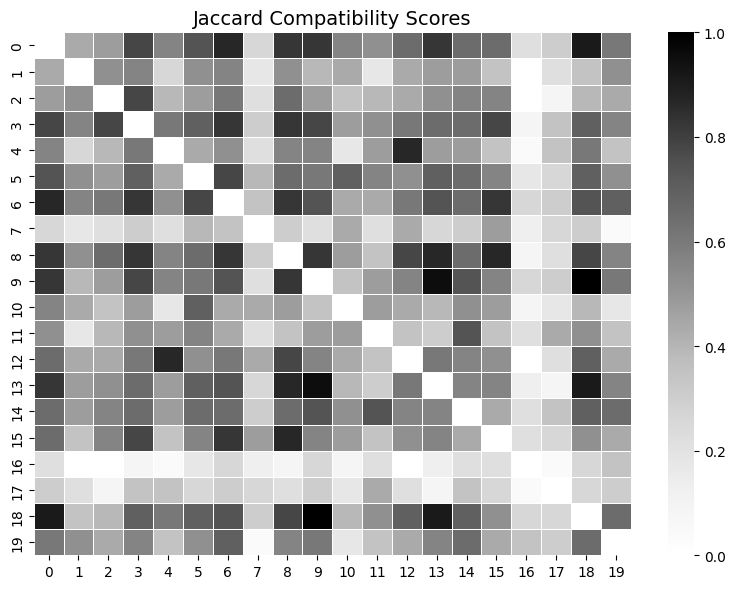

In [24]:
#@title Calculates compatibility scores using a specified similarity metric, converts the scores to a matrix, and visualizes the results using a heatmap.

#@markdown This code calculates compatibility scores between individuals using a specified type of similarity metric (e.g., "Jaccard") and stores the results in a dictionary. The compatibility scores are then converted into a symmetric matrix, which is visualized as a heatmap. The scores can be normalized to a range of [0, 1] before plotting.
"""
Calculates compatibility scores using a specified similarity metric, converts the scores to a matrix, and visualizes the results using a heatmap.

This code calculates compatibility scores between individuals using a specified type of similarity metric
(e.g., "Jaccard") and stores the results in a dictionary. The compatibility scores are then converted into
a symmetric matrix, which is visualized as a heatmap. The scores can be normalized to a range of [0, 1]
before plotting.

Steps:
    1. Set the type of similarity score to use (e.g., "Jaccard").
    2. Calculate the compatibility scores using the specified type and store them in the `compatibility_scores_dict` dictionary.
    3. Extract all unique individual IDs involved in the compatibility scores and determine the number of individuals.
    4. If the scores exist in the dictionary for the selected type, convert the scores into a symmetric matrix.
    5. Plot a heatmap to visualize the compatibility matrix using the `plot_heatmap` function.

Args:
    people_data (pd.DataFrame): A DataFrame containing individual attributes for which the compatibility scores
        are to be calculated.
    type_scores (str): The type of similarity metric to use for compatibility calculation (e.g., "Jaccard",
        "Cosine").
    normalize (bool, optional): Whether to normalize the compatibility scores to a range of [0, 1]. Default is True.
    compatibility_scores_dict (dict): A dictionary to store the compatibility scores for each pair of individuals.
    individual_ids (list): A list of unique individual IDs involved in the compatibility calculation.
    setting_key (str): The key in the `compatibility_scores_dict` corresponding to the selected similarity metric.
    scores_to_matrix (function): A function that converts the compatibility scores dictionary into a symmetric matrix.
    plot_heatmap (function): A function that generates a heatmap from the symmetric matrix of compatibility scores.

Returns:
    None: This function generates and displays a heatmap of compatibility scores between individuals.

Example:
    >>> # Set the type of similarity score to use (e.g., "Jaccard")
    >>> type_scores = "Jaccard"

    >>> # Initialize a dictionary to store the compatibility scores
    >>> compatibility_scores_dict = {}

    >>> # Calculate compatibility scores using the specified type and normalization
    >>> compatibility_scores_dict[type_scores], time_elapsed = compatibility_scores(people_data, type=type_scores, normalize=True)

    >>> # Extract all unique individual IDs involved in the compatibility scores
    >>> individual_ids = list(set(id_ for scores in compatibility_scores_dict.values() for pair in scores.keys() for id_ in pair))
    >>> num_individuals = len(individual_ids)

    >>> # Convert the scores dictionary to a symmetric matrix and plot the heatmap
    >>> if type_scores in compatibility_scores_dict:
    >>>     scores = compatibility_scores_dict[type_scores]
    >>>     matrix = scores_to_matrix(scores, individual_ids)
    >>>     plot_heatmap(matrix, f'{type_scores} Compatibility Scores')
"""
# Set the type of similarity score to use (e.g., "Jaccard")
type_scores = "Jaccard"

# Initialize a dictionary to store the compatibility scores
compatibility_scores_dict = {}

# Calculate compatibility scores using the specified type and normalization
compatibility_scores_dict[type_scores], time_elapsed = compatibility_scores(people_data, type=type_scores, normalize=True)

# Extract all unique individual IDs involved in the compatibility scores
individual_ids = list(set(id_ for scores in compatibility_scores_dict.values() for pair in scores.keys() for id_ in pair))
num_individuals = len(individual_ids)

# Set the key for compatibility scores based on the selected type
setting_key = type_scores

# If the scores exist in the dictionary, convert them to a matrix and plot the heatmap
if setting_key in compatibility_scores_dict:
    scores = compatibility_scores_dict[setting_key]

    # Convert the scores dictionary to a symmetric matrix
    matrix = scores_to_matrix(scores, individual_ids)

    # Plot the heatmap of the compatibility matrix
    plot_heatmap(matrix, f'{setting_key} Compatibility Scores')
else:
    print(f"Scores for {setting_key} not found.")


## Applying Matching Algorithms

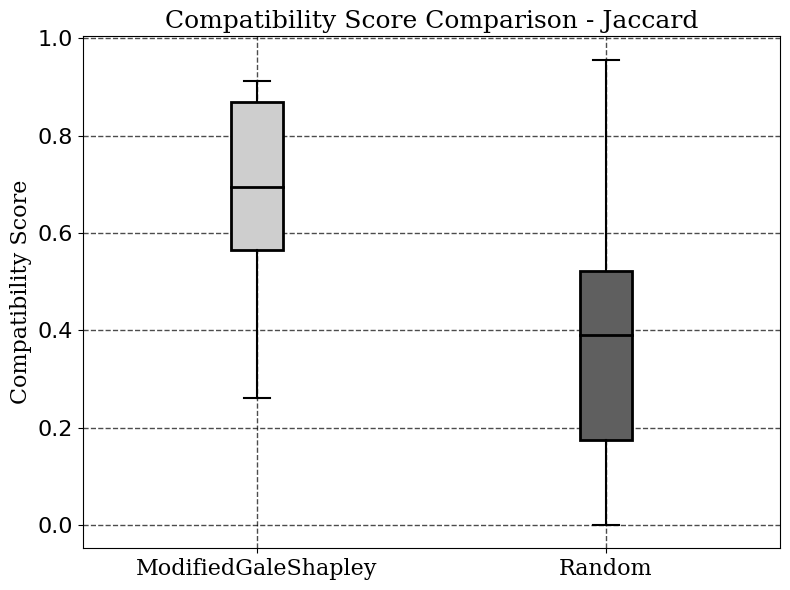

,count,mean,std,min,25%,median,75%,max,execution_time,iterations
ModifiedGaleShapley,10.0,0.660870,0.235586,0.26087,0.565217,0.695652,0.869565,0.913043,0.001215,17.0
Random,10.0,0.408696,0.327215,0.00000,0.173913,0.391304,0.521739,0.956522,0.000047,0.0


In [25]:
#@title Applies matching algorithms (e.g., Gale-Shapley and random matching) to the dataset, analyzes the results, and returns statistical summaries.

#@markdown This code applies different matching algorithms to the dataset (`people_data`) and analyzes the resulting matched pairs. The results of each algorithm are compared, and statistical summaries of the compatibility distributions are returned. The results are stored in a DataFrame (`statistics_df`), and the matched pairs are returned in a dictionary (`matched_pairs`).

"""
Applies matching algorithms (e.g., Gale-Shapley and random matching) to the dataset, analyzes the results, and returns statistical summaries.

This code applies different matching algorithms to the dataset (`people_data`) and analyzes the
resulting matched pairs. The results of each algorithm are compared, and statistical summaries
of the compatibility distributions are returned. The results are stored in a DataFrame (`statistics_df`),
and the matched pairs are returned in a dictionary (`matched_pairs`).

Steps:
    1. Apply the matching algorithms (e.g., Modified Gale-Shapley, random matching) to the input data.
    2. Analyze the results, calculating compatibility scores and other relevant metrics.
    3. Generate a DataFrame containing statistical summaries of the compatibility distributions
       for each algorithm (e.g., mean, median, standard deviation).
    4. Return the matched pairs generated by each algorithm for further analysis or visualization.

Args:
    people_data (pd.DataFrame): The input DataFrame containing individual attributes to be matched.
    compatibility_scores_dict (dict): A dictionary containing compatibility scores for all possible
        pairs of individuals.
    seed (int, optional): A random seed used to ensure reproducibility of the random matching algorithm.
        Default is 23.

Returns:
    statistics_df (pd.DataFrame): A DataFrame containing statistical summaries of the compatibility
        distributions for each matching algorithm.
    matched_pairs (dict): A dictionary containing the matched pairs generated by each matching algorithm
        (e.g., Modified Gale-Shapley and random matching).

Example:
    >>> # Apply matching algorithms and analyze the results
    >>> statistics_df, matched_pairs = apply_matching_and_analyze(people_data, compatibility_scores_dict, seed=23)

    >>> # Display the DataFrame with statistical summaries of the compatibility distributions
    >>> statistics_df
"""
# Apply matching algorithms and analyze the results (e.g., using Gale-Shapley or random matching)
statistics_df, matched_pairs = apply_matching_and_analyze(people_data, compatibility_scores_dict, seed=23)

# Display the DataFrame with statistical summaries of the compatibility distributions
statistics_df


## Bipartite Graph

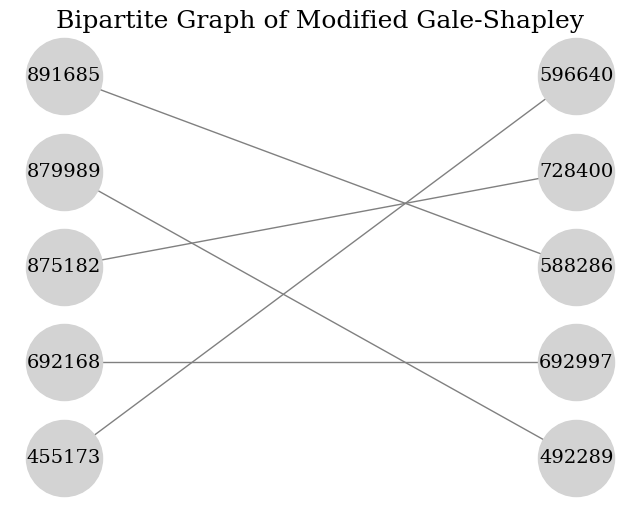

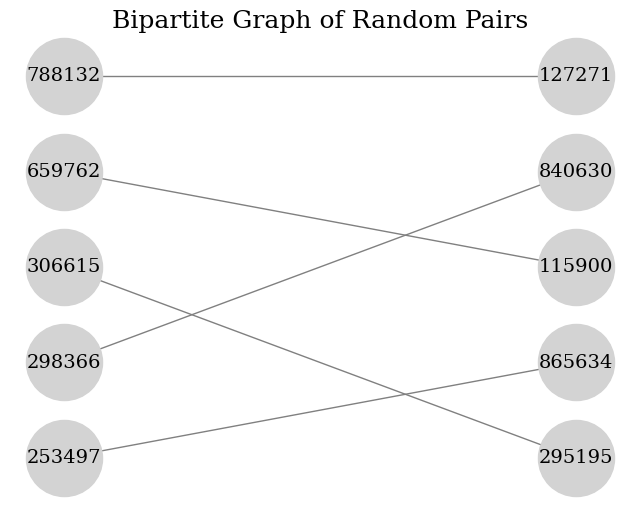

In [26]:
#@title Visualizes matched pairs using bipartite graphs for both the Modified Gale-Shapley algorithm and the Random matching algorithm.

#@markdown This code visualizes the matched pairs generated by two different algorithms: Modified Gale-Shapley and Random matching. The matched pairs are represented as bipartite graphs, where nodes represent individuals, and edges connect matched pairs.

"""
Visualizes matched pairs using bipartite graphs for both the Modified Gale-Shapley algorithm and the Random matching algorithm.

This code visualizes the matched pairs generated by two different algorithms:
Modified Gale-Shapley and Random matching. The matched pairs are represented as
bipartite graphs, where nodes represent individuals, and edges connect matched pairs.

Steps:
    1. The matched pairs generated by the Modified Gale-Shapley algorithm are visualized
       as a bipartite graph using the `pairs_to_bipartite_graph` function.
    2. The matched pairs generated by the Random matching algorithm are visualized in a
       similar manner, with each pair connected by an edge in the bipartite graph.

Args:
    matched_pairs (dict): A dictionary containing matched pairs, with keys representing
        the matching method ("ModifiedGaleShapley" and "Random"). Each key points to another
        dictionary where individuals are paired based on the algorithm.
    pairs_to_bipartite_graph (function): A function used to create and display a bipartite
        graph from a list of matched pairs.
    "Bipartite Graph of Modified Gale-Shapley" (str): The title of the bipartite graph for
        the Modified Gale-Shapley matching.
    "Bipartite Graph of Random Pairs" (str): The title of the bipartite graph for the Random matching.

Returns:
    None: This function generates and displays bipartite graphs for both the Modified
    Gale-Shapley and Random matching algorithms.

Example:
    >>> # Visualize the matched pairs using the modified Gale-Shapley algorithm
    >>> pairs_to_bipartite_graph(matched_pairs['ModifiedGaleShapley'], "Bipartite Graph of Modified Gale-Shapley")

    >>> # Visualize the matched pairs using the random matching algorithm
    >>> pairs_to_bipartite_graph(matched_pairs['Random'], "Bipartite Graph of Random Pairs")
"""
# Visualize the matched pairs using the modified Gale-Shapley algorithm
pairs_to_bipartite_graph(matched_pairs['ModifiedGaleShapley'], "Bipartite Graph of Modified Gale-Shapley")

# Visualize the matched pairs using the random matching algorithm
pairs_to_bipartite_graph(matched_pairs['Random'], "Bipartite Graph of Random Pairs")


# Pairs Diference Performance

In [27]:
# @title Converts performance data into a pandas DataFrame and sets 'user_name' as the index.

"""
Converts performance data into a pandas DataFrame and sets 'user_name' as the index.

This code takes a list of dictionaries (`data_performance`), where each dictionary represents
an individual's performance metrics, and converts it into a pandas DataFrame. The 'user_name'
field is set as the index of the DataFrame, allowing for easier access to individual performance
records.

Data fields include:
    - `user_name`: The unique identifier for each user.
    - `score`: The user's performance score.
    - `correct_count`: The number of correct answers.
    - `wrong_count`: The number of incorrect answers.
    - `average_elapsed_time`: The average time taken per task.
    - `total_elapsed_time`: The total time spent.

Steps:
    1. Convert the list of dictionaries (`data_performance`) into a pandas DataFrame using `pd.json_normalize`.
    2. Set the 'user_name' column as the index for easy access to individual records.
    3. Display the resulting DataFrame containing performance metrics.

Returns:
    pd.DataFrame: The resulting DataFrame with 'user_name' as the index, showing performance data for all users.

Example:
    >>> data_performance = [{"user_name":115900,"score":2526,...}]
    >>> df_performance = pd.json_normalize(data_performance)
    >>> df_performance = df_performance.set_index("user_name")
    >>> df_performance
             score  correct_count  wrong_count  average_elapsed_time  total_elapsed_time
    user_name
    115900     2526             28           31                   59                1596
    127271      524             10           35                  100                 807
    ...

"""

# Performance data
data_performance = [{"user_name":115900,"score":2526,"correct_count":28,"wrong_count":31,"average_elapsed_time":59,"total_elapsed_time":1596},
{"user_name":127271,"score":524,"correct_count":10,"wrong_count":35,"average_elapsed_time":100,"total_elapsed_time":807},
{"user_name":253497,"score":2108,"correct_count":15,"wrong_count":3,"average_elapsed_time":38,"total_elapsed_time":498},
{"user_name":295195,"score":3412,"correct_count":29,"wrong_count":4,"average_elapsed_time":71,"total_elapsed_time":1924},
{"user_name":298366,"score":1600,"correct_count":22,"wrong_count":40,"average_elapsed_time":87,"total_elapsed_time":1579},
{"user_name":306615,"score":2464,"correct_count":24,"wrong_count":17,"average_elapsed_time":100,"total_elapsed_time":2706},
{"user_name":455173,"score":3136,"correct_count":27,"wrong_count":8,"average_elapsed_time":49,"total_elapsed_time":1336},
{"user_name":492289,"score":2852,"correct_count":27,"wrong_count":17,"average_elapsed_time":56,"total_elapsed_time":1519},
{"user_name":588286,"score":2494,"correct_count":30,"wrong_count":39,"average_elapsed_time":55,"total_elapsed_time":1491},
{"user_name":596640,"score":3702,"correct_count":35,"wrong_count":16,"average_elapsed_time":46,"total_elapsed_time":1257},
{"user_name":659762,"score":1480,"correct_count":14,"wrong_count":14,"average_elapsed_time":137,"total_elapsed_time":1516},
{"user_name":692168,"score":2020,"correct_count":28,"wrong_count":49,"average_elapsed_time":42,"total_elapsed_time":1142},
{"user_name":692997,"score":3440,"correct_count":28,"wrong_count":2,"average_elapsed_time":37,"total_elapsed_time":1004},
{"user_name":728400,"score":1966,"correct_count":15,"wrong_count":8,"average_elapsed_time":34,"total_elapsed_time":514},
{"user_name":788132,"score":2968,"correct_count":26,"wrong_count":10,"average_elapsed_time":53,"total_elapsed_time":1289},
{"user_name":840630,"score":3414,"correct_count":29,"wrong_count":5,"average_elapsed_time":55,"total_elapsed_time":1500},
{"user_name":865634,"score":2840,"correct_count":25,"wrong_count":11,"average_elapsed_time":52,"total_elapsed_time":1407},
{"user_name":875182,"score":3148,"correct_count":28,"wrong_count":11,"average_elapsed_time":48,"total_elapsed_time":1314},
{"user_name":879989,"score":1228,"correct_count":12,"wrong_count":18,"average_elapsed_time":103,"total_elapsed_time":1032},
{"user_name":891685,"score":3192,"correct_count":30,"wrong_count":16,"average_elapsed_time":51,"total_elapsed_time":1387}]

# Converting the list of dictionaries to a DataFrame
df_performance = pd.json_normalize(data_performance)

# Setting 'user_name' as the index
df_performance = df_performance.set_index("user_name")

# Displaying the DataFrame
df_performance

,score,correct_count,wrong_count,average_elapsed_time,total_elapsed_time
user_name,,,,,
115900,2526,28,31,59,1596
127271,524,10,35,100,807
253497,2108,15,3,38,498
295195,3412,29,4,71,1924
298366,1600,22,40,87,1579
306615,2464,24,17,100,2706
455173,3136,27,8,49,1336
492289,2852,27,17,56,1519
588286,2494,30,39,55,1491


In [28]:
# @title Compares performance metrics for pairs generated by Modified Gale-Shapley and Random pairing methods.

"""
Compares performance metrics for pairs generated by Modified Gale-Shapley and Random pairing methods.

This code calculates performance metrics for pairs of individuals matched using two methods:
Modified Gale-Shapley and Random pairing. It computes metrics such as averages, differences,
and standard deviations for various performance attributes, and then combines the results into
a single DataFrame for comparison.

Steps:
    1. Extracts matched pairs for both Modified Gale-Shapley and Random methods.
    2. Calculates performance metrics for both sets of pairs using the `calculate_pair_metrics` function.
    3. Converts the resulting dictionaries of metrics into pandas DataFrames.
    4. Adds a column indicating the pairing method ("Modified GS" or "Random").
    5. Concatenates the DataFrames into a single DataFrame containing all metrics.
    6. Resets the index to include the pair identifier as a regular column.
    7. Displays the combined DataFrame.

Args:
    matched_pairs (dict): A dictionary containing the matched pairs for different methods
        ('ModifiedGaleShapley' and 'Random'). Keys are individual identifiers, and values
        are their matched pairs.
    df_performance (pd.DataFrame): A DataFrame containing performance data for each individual,
        indexed by their unique identifier (user_name). It includes performance metrics such as
        'score', 'correct_count', 'wrong_count', 'average_elapsed_time', and 'total_elapsed_time'.

Returns:
    pd.DataFrame: A DataFrame containing the calculated performance metrics for each pair, along
    with a column identifying which pairing method was used ('Modified GS' or 'Random').

Example:
    # Given matched pairs and performance data:
    modified_pairs = matched_pairs["ModifiedGaleShapley"]
    random_pairs = matched_pairs["Random"]

    # Calculate performance metrics
    modified_metrics = calculate_pair_metrics(modified_pairs, df_performance)
    random_metrics = calculate_pair_metrics(random_pairs, df_performance)

    # Convert metrics to DataFrames and add a 'method' column
    df_modified_metrics = pd.DataFrame.from_dict(modified_metrics, orient='index')
    df_random_metrics = pd.DataFrame.from_dict(random_metrics, orient='index')
    df_modified_metrics['method'] = 'Modified GS'
    df_random_metrics['method'] = 'Random'

    # Concatenate and reset index
    df_all_metrics = pd.concat([df_modified_metrics, df_random_metrics])
    df_all_metrics = df_all_metrics.reset_index().rename(columns={'index': 'pair'})

    # Display combined DataFrame
    df_all_metrics
"""
# Extracting matched pairs from the matched_pairs dictionary
modified_pairs = matched_pairs["ModifiedGaleShapley"]
random_pairs = matched_pairs["Random"]

# Calculating metrics for both pairing methods
modified_metrics = calculate_pair_metrics(modified_pairs, df_performance)
random_metrics = calculate_pair_metrics(random_pairs, df_performance)

# Converting the metrics dictionaries into DataFrames
df_modified_metrics = pd.DataFrame.from_dict(modified_metrics, orient='index')
df_random_metrics = pd.DataFrame.from_dict(random_metrics, orient='index')

# Adding a 'method' column to identify which pairing method was used
df_modified_metrics['method'] = 'Modified GS'
df_random_metrics['method'] = 'Random'

# Concatenating the DataFrames
df_all_metrics = pd.concat([df_modified_metrics, df_random_metrics])

# Resetting the index to make the pair identifier a regular column
df_all_metrics = df_all_metrics.reset_index().rename(columns={'index': 'pair'})

# Display the combined DataFrame
df_all_metrics


,pair,avg_score,diff_score,std_score,avg_correct_count,diff_correct_count,std_correct_count,avg_wrong_count,diff_wrong_count,std_wrong_count,avg_average_elapsed_time,diff_average_elapsed_time,std_average_elapsed_time,avg_total_elapsed_time,diff_total_elapsed_time,std_total_elapsed_time,method
0,879989-492289,2040.0,1624,812.0,19.5,15,7.5,17.5,1,0.5,79.5,47,23.5,1275.5,487,243.5,Modified GS
1,875182-728400,2557.0,1182,591.0,21.5,13,6.5,9.5,3,1.5,41.0,14,7.0,914.0,800,400.0,Modified GS
2,891685-588286,2843.0,698,349.0,30.0,0,0.0,27.5,23,11.5,53.0,4,2.0,1439.0,104,52.0,Modified GS
3,492289-879989,2040.0,1624,812.0,19.5,15,7.5,17.5,1,0.5,79.5,47,23.5,1275.5,487,243.5,Modified GS
4,588286-891685,2843.0,698,349.0,30.0,0,0.0,27.5,23,11.5,53.0,4,2.0,1439.0,104,52.0,Modified GS
5,728400-875182,2557.0,1182,591.0,21.5,13,6.5,9.5,3,1.5,41.0,14,7.0,914.0,800,400.0,Modified GS
6,692168-692997,2730.0,1420,710.0,28.0,0,0.0,25.5,47,23.5,39.5,5,2.5,1073.0,138,69.0,Modified GS
7,692997-692168,2730.0,1420,710.0,28.0,0,0.0,25.5,47,23.5,39.5,5,2.5,1073.0,138,69.0,Modified GS
8,455173-596640,3419.0,566,283.0,31.0,8,4.0,12.0,8,4.0,47.5,3,1.5,1296.5,79,39.5,Modified GS
9,596640-455173,3419.0,566,283.0,31.0,8,4.0,12.0,8,4.0,47.5,3,1.5,1296.5,79,39.5,Modified GS


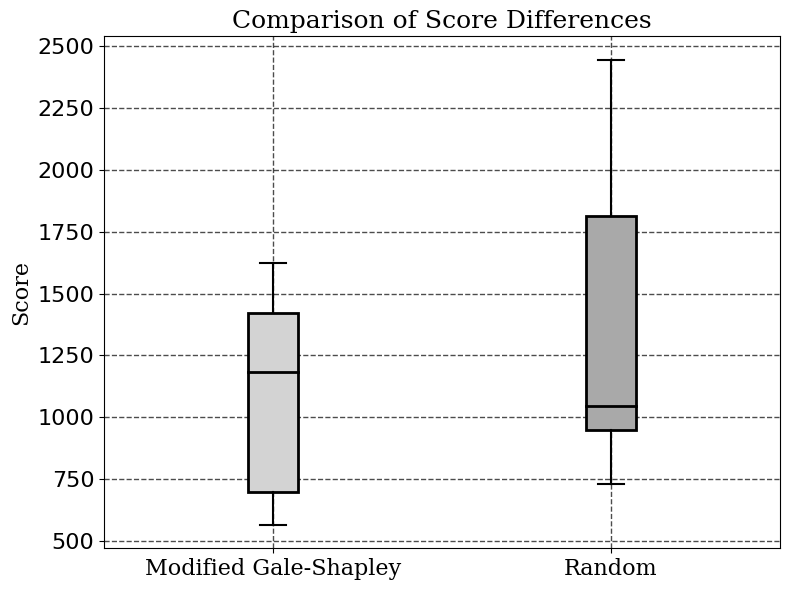

In [43]:
# @title Compares the difference in scores between Modified Gale-Shapley and Random pairing methods using a box plot.

# @markdown This code prepares data for visualizing the difference in scores (`diff_score`) between pairs generated by the Modified Gale-Shapley and Random pairing methods. It then generates a box plot to compare the distribution of these score differences.

"""
Compares the difference in scores between Modified Gale-Shapley and Random pairing methods using a box plot.

This code prepares data for visualizing the difference in scores (`diff_score`) between pairs generated by
the Modified Gale-Shapley and Random pairing methods. It then generates a box plot to compare the
distribution of these score differences.

Steps:
    1. Extracts the `diff_score` values from `df_all_metrics` for both pairing methods: 'Modified GS' and 'Random'.
    2. Prepares the data in a format suitable for plotting, with labels for each method.
    3. Calls the `plot_comparison_boxplots_score` function to create a box plot comparing the score differences
       between the two pairing methods.

Args:
    df_all_metrics (pd.DataFrame): A DataFrame containing performance metrics for each pair, including
        score differences (`diff_score`) and the method used for pairing (`method`).
    data_to_plot (list of np.ndarray): A list containing the `diff_score` values for both the Modified GS
        and Random methods.
    labels (list of str): A list of method labels for the x-axis, typically ['Modified Gale-Shapley', 'Random'].
    plot_comparison_boxplots_score (function): A function used to create and display the box plot comparing
        the score differences between the two methods.
    colors (list of str): A list of colors used to style the box plots for each method.

Example:
    # Prepare data for plotting
    data_to_plot = [
        df_all_metrics[df_all_metrics['method'] == 'Modified GS']['diff_score'].values,
        df_all_metrics[df_all_metrics['method'] == 'Random']['diff_score'].values
    ]
    labels = ['Modified Gale-Shapley', 'Random']

    # Create the box plot
    plot_comparison_boxplots_score(
        data_to_plot,
        'Comparison of Score Differences',
        'Score',
        labels,
        colors=['lightgray', 'darkgray']
    )
"""
# Prepare data for plotting
data_to_plot = [
    df_all_metrics[df_all_metrics['method'] == 'Modified GS']['diff_score'].values,
    df_all_metrics[df_all_metrics['method'] == 'Random']['diff_score'].values
]
labels = ['Modified Gale-Shapley', 'Random']

# Create the box plot
plot_comparison_boxplots_score(
    data_to_plot,
    'Comparison of Score Differences',
    'Score',
    labels,
    colors=['lightgray', 'darkgray']
)


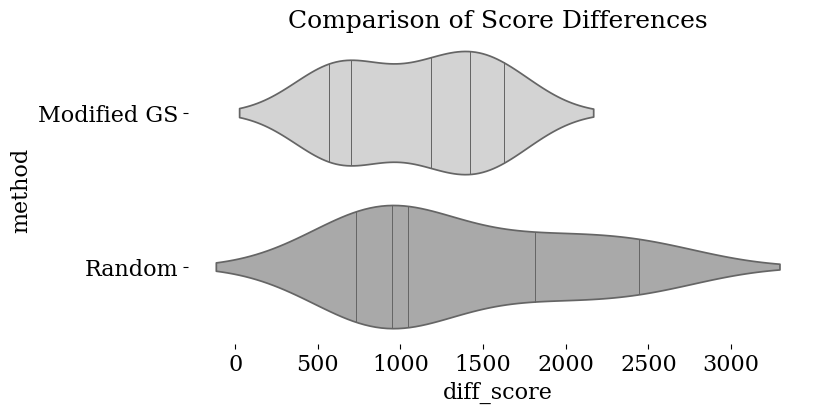

In [44]:
# @title Plots the distribution of score differences between Modified Gale-Shapley and Random pairing methods.

"""
Plots the distribution of score differences between Modified Gale-Shapley and Random pairing methods.

This code generates a violin plot to compare the distribution of score differences (`diff_score`)
between pairs generated by two pairing methods: Modified Gale-Shapley and Random. The method names
are displayed on the y-axis, and the differences in scores are shown on the x-axis.

Args:
    df_all_metrics (pd.DataFrame): A DataFrame containing performance metrics for each pair,
        including the `diff_score` column, which represents the difference in scores between
        matched pairs, and the `method` column, which indicates the pairing method used
        ('Modified GS' or 'Random').
    plot_resuls (function): A function that creates a violin plot comparing the distribution
        of score differences between the two pairing methods.
    'diff_score' (str): The column name in `df_all_metrics` used for the x-axis (difference in scores).
    'method' (str): The column name in `df_all_metrics` used for the y-axis (pairing method).
    'Comparison of Scores Difference' (str): The title of the plot.

Example:
    # Generate violin plot comparing score differences between Modified GS and Random methods
    plot_resuls(df_all_metrics, 'diff_score', 'method', 'Comparison of Score Differences')
"""
# Generate violin plot comparing score differences between Modified GS and Random methods
plot_results(df_all_metrics, 'diff_score', 'method', 'Comparison of Score Differences')


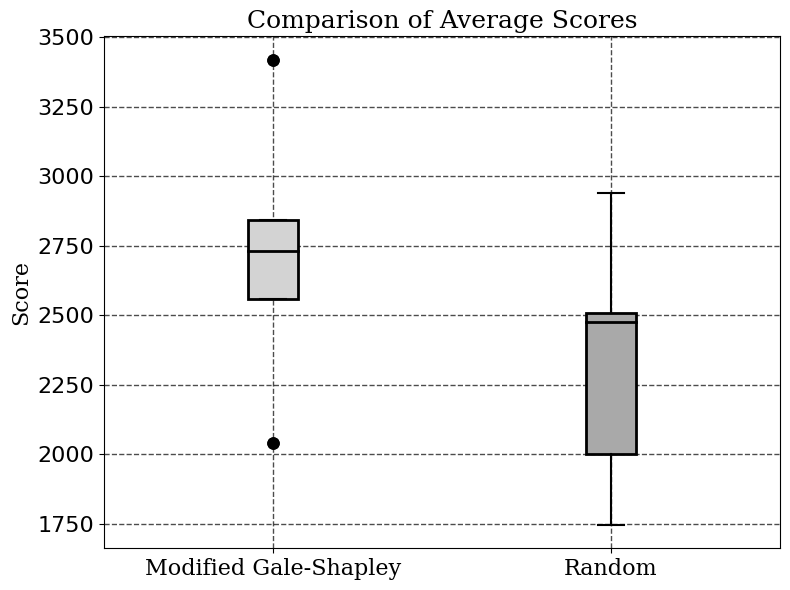

In [32]:
# @title Compares the average scores between the Modified Gale-Shapley and Random pairing methods using a box plot.

"""
Compares the average scores between the Modified Gale-Shapley and Random pairing methods using a box plot.

This code extracts the average scores (`avg_score`) for pairs generated by two different methods:
Modified Gale-Shapley and Random pairing. It then generates a box plot to visualize and compare
the distribution of average scores for each method.

Steps:
    1. Extracts `avg_score` values from `df_all_metrics` for both the 'Modified GS' and 'Random' pairing methods.
    2. Prepares the extracted data for plotting by placing the scores for each method into a list.
    3. Calls the `plot_comparison_boxplots_score` function to create a box plot comparing the distribution
       of average scores between the two methods.

Args:
    df_all_metrics (pd.DataFrame): A DataFrame containing performance metrics for each pair,
        including the `avg_score` column (average score for the pair) and the `method` column
        (indicating whether the pair was matched using the Modified Gale-Shapley or Random method).
    modified_scores_avg (np.ndarray): An array of average scores for pairs matched using the
        Modified Gale-Shapley method.
    random_scores_avg (np.ndarray): An array of average scores for pairs matched using the
        Random method.
    data_to_plot (list of np.ndarray): A list containing the average scores for both methods
        (Modified Gale-Shapley and Random).
    labels (list of str): A list of method labels for the x-axis, typically
        ['Modified Gale-Shapley', 'Random'].
    plot_comparison_boxplots_score (function): A function used to create and display the box plot
        comparing the average scores between the two methods.
    colors (list of str): A list of colors used to style the box plots for each method.

Returns:
    None: The function generates and displays a box plot comparing average scores across both methods.

Example:
    # Extract scores for each method
    modified_scores_avg = df_all_metrics[df_all_metrics['method'] == 'Modified GS']['avg_score'].values
    random_scores_avg = df_all_metrics[df_all_metrics['method'] == 'Random']['avg_score'].values

    # Prepare data for plotting
    data_to_plot = [modified_scores_avg, random_scores_avg]
    labels = ['Modified Gale-Shapley', 'Random']

    # Create the box plot
    plot_comparison_boxplots_score(
        data_to_plot,
        'Comparison of Average Scores',
        'Score',
        labels,
        colors=['lightgray', 'darkgray']
    )
"""
# Extract scores for each method
modified_scores_avg = df_all_metrics[df_all_metrics['method'] == 'Modified GS']['avg_score'].values
random_scores_avg = df_all_metrics[df_all_metrics['method'] == 'Random']['avg_score'].values

# Prepare data for plotting
data_to_plot = [modified_scores_avg, random_scores_avg]
labels = ['Modified Gale-Shapley', 'Random']

# Create the box plot
plot_comparison_boxplots_score(
    data_to_plot,
    'Comparison of Average Scores',
    'Score',
    labels,
    colors=['lightgray', 'darkgray']
)


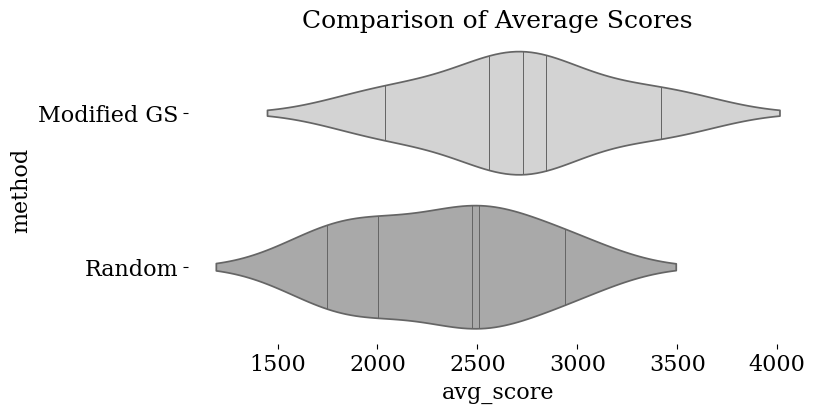

In [33]:
# @title Plots the distribution of average scores between Modified Gale-Shapley and Random pairing methods.

"""
Plots the distribution of average scores between Modified Gale-Shapley and Random pairing methods.

This code generates a violin plot to compare the distribution of average scores (`avg_score`)
between pairs matched using the Modified Gale-Shapley and Random pairing methods. The pairing
method is displayed on the x-axis, and the average score is represented on the y-axis.

Args:
    df_all_metrics (pd.DataFrame): A DataFrame containing performance metrics for each pair,
        including the `avg_score` column (representing the average score for the pair) and
        the `method` column (indicating whether the pair was matched using the Modified
        Gale-Shapley or Random method).
    'avg_score' (str): The column name in `df_all_metrics` representing the scores, used for the y-axis.
    'method' (str): The column name in `df_all_metrics` representing the pairing method, used for the x-axis.
    'Comparison of Average Scores' (str): The title of the plot.

Returns:
    None: This function generates and displays a violin plot comparing average scores across the two pairing methods.

Example:
    # Generate a violin plot comparing average scores between Modified Gale-Shapley and Random methods
    plot_resuls(df_all_metrics, 'avg_score', 'method', 'Comparison of Average Scores')
"""
# Generate a violin plot comparing average scores between Modified Gale-Shapley and Random methods
plot_results(df_all_metrics, 'avg_score', 'method', 'Comparison of Average Scores')


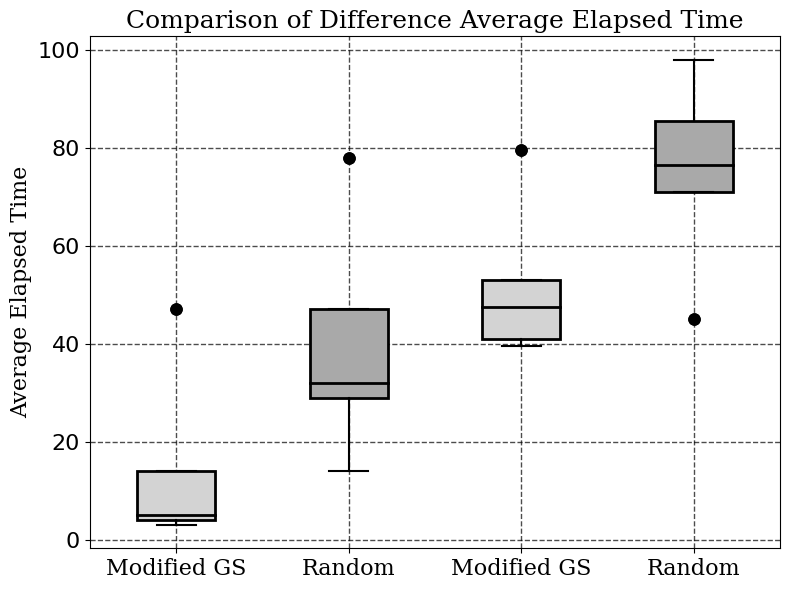

In [35]:
# @title Plots a comparison of the difference and average elapsed time between Modified Gale-Shapley and Random pairing methods using a box plot.

# @markdown This code prepares and plots the comparison of the difference and average elapsed time (`diff_average_elapsed_time` and `avg_average_elapsed_time`) between pairs matched using the Modified Gale-Shapley and Random pairing methods. The box plot visualizes the distribution of these metrics for both methods.

"""
Plots a comparison of the difference and average elapsed time between Modified Gale-Shapley and Random pairing methods using a box plot.

This code prepares and plots the comparison of the difference and average elapsed time
(`diff_average_elapsed_time` and `avg_average_elapsed_time`) between pairs matched using the
Modified Gale-Shapley and Random pairing methods. The box plot visualizes the distribution of
these metrics for both methods.

Steps:
    1. Extracts the `diff_average_elapsed_time` and `avg_average_elapsed_time` values from
       `df_all_metrics` for both the 'Modified GS' and 'Random' pairing methods.
    2. Prepares the data for plotting, storing the difference and average elapsed time values
       in a list for each method.
    3. Calls the `plot_comparison_boxplots_score` function to generate a box plot comparing the
       metrics for the two pairing methods.

Args:
    df_all_metrics (pd.DataFrame): A DataFrame containing performance metrics for each pair,
        including the `diff_average_elapsed_time` and `avg_average_elapsed_time` columns
        (representing the difference and average elapsed time for each pair) and the `method`
        column (indicating whether the pair was matched using the Modified Gale-Shapley or Random method).
    data_to_plot (list of np.ndarray): A list containing the difference and average elapsed time values
        for both methods (Modified Gale-Shapley and Random).
    labels (list of str): A list of method labels for the x-axis, typically ['Modified GS', 'Random', 'Modified GS', 'Random'].
    plot_comparison_boxplots_score (function): A function used to create and display the box plot
        comparing the difference and average elapsed times between the two methods.
    colors (list of str): A list of colors used to style the box plots for each method.

Returns:
    None: This function generates and displays a box plot comparing the difference and average elapsed times
    across both pairing methods.

Example:
    # Prepare data for plotting
    data_to_plot = [
        df_all_metrics[df_all_metrics['method'] == 'Modified GS']['diff_average_elapsed_time'].values,
        df_all_metrics[df_all_metrics['method'] == 'Random']['diff_average_elapsed_time'].values,
        df_all_metrics[df_all_metrics['method'] == 'Modified GS']['avg_average_elapsed_time'].values,
        df_all_metrics[df_all_metrics['method'] == 'Random']['avg_average_elapsed_time'].values
    ]
    labels = ['Modified GS', 'Random', 'Modified GS', 'Random']

    # Create the box plot
    plot_comparison_boxplots_score(
        data_to_plot,
        'Comparison of Average Elapsed Time',
        'Average Elapsed Time',
        labels,
        colors=['lightgray', 'darkgray', 'lightgray', 'darkgray']
    )
"""
# Prepare data for plotting
data_to_plot = [
    df_all_metrics[df_all_metrics['method'] == 'Modified GS']['diff_average_elapsed_time'].values,
    df_all_metrics[df_all_metrics['method'] == 'Random']['diff_average_elapsed_time'].values,
    df_all_metrics[df_all_metrics['method'] == 'Modified GS']['avg_average_elapsed_time'].values,
    df_all_metrics[df_all_metrics['method'] == 'Random']['avg_average_elapsed_time'].values
]

labels = ['Modified GS', 'Random', 'Modified GS', 'Random']

# Create the box plot
plot_comparison_boxplots_score(
    data_to_plot,
    'Comparison of Difference Average Elapsed Time',
    'Average Elapsed Time',
    labels,
    colors=['lightgray', 'darkgray', 'lightgray', 'darkgray']
)


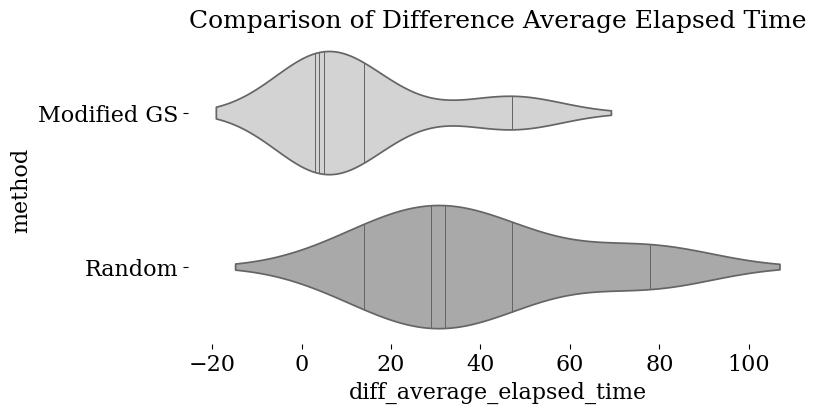

In [36]:
# @title Plots the distribution of the difference in average elapsed time between Modified Gale-Shapley and Random pairing methods.

# @markdown This function generates a violin plot comparing the distribution of the difference in average elapsed time (`diff_average_elapsed_time`) for pairs matched using the Modified Gale-Shapley and Random pairing methods. The pairing method is displayed on the x-axis, and the difference in average elapsed time is represented on the y-axis.

"""
Plots the distribution of the difference in average elapsed time between Modified Gale-Shapley and Random pairing methods.

This function generates a violin plot comparing the distribution of the difference in average elapsed time
(`diff_average_elapsed_time`) for pairs matched using the Modified Gale-Shapley and Random pairing methods.
The pairing method is displayed on the x-axis, and the difference in average elapsed time is represented
on the y-axis.

Args:
    df_all_metrics (pd.DataFrame): A DataFrame containing performance metrics for each pair,
        including the `diff_average_elapsed_time` column (representing the difference in
        average elapsed time between matched pairs) and the `method` column (indicating
        whether the pair was matched using the Modified Gale-Shapley or Random method).
    'diff_average_elapsed_time' (str): The column name in `df_all_metrics` representing the difference in average elapsed time, used for the y-axis.
    'method' (str): The column name in `df_all_metrics` representing the pairing method, used for the x-axis.
    'Comparison of Difference Average Elapsed Time' (str): The title of the plot.

Returns:
    None: This function generates and displays a violin plot comparing the difference in average elapsed time
    across the two pairing methods.

Example:
    # Generate a violin plot comparing the difference in average elapsed time between Modified GS and Random methods
    plot_resuls(df_all_metrics, 'diff_average_elapsed_time', 'method', 'Comparison of Difference Average Elapsed Time')
"""
# Generate a violin plot comparing the difference in average elapsed time between Modified GS and Random methods
plot_results(df_all_metrics, 'diff_average_elapsed_time', 'method', 'Comparison of Difference Average Elapsed Time')


# Dataset Research

In [45]:
#@title Converts a list of research survey responses into a pandas DataFrame for analysis.

#@markdown This code takes a list of dictionaries (`research_data`), where each dictionary represents an individual's response to various questions about their engagement with an educational game. Each dictionary contains fields such as age, gender, engagement level, and responses to questions about motivation, learning, and challenge level. The `pd.json_normalize()` function is used to convert this list into a pandas DataFrame (`research_df`), where each dictionary in the list becomes a row in the DataFrame, and the keys become the column headers.

"""
Converts a list of research survey responses into a pandas DataFrame for analysis.

This code takes a list of dictionaries (`research_data`), where each dictionary represents an individual's
response to various questions about their engagement with an educational game. Each dictionary contains
fields such as age, gender, engagement level, and responses to questions about motivation, learning,
and challenge level.

The `pd.json_normalize()` function is used to convert this list into a pandas DataFrame (`research_df`),
where each dictionary in the list becomes a row in the DataFrame, and the keys become the column headers.

Fields include:
    - `Age`: The age of the participant.
    - `Gender`: The gender of the participant.
    - `Engagement level`: The participant's level of engagement with the educational game (e.g., "Engaged", "Neutral").
    - `Did the game help you learn?`: Whether the participant felt the game contributed to their learning.
    - `How challenging are the game's puzzles?`: The participant's perception of the difficulty of the game's puzzles.
    - `Did you feel motivated to solve the game's challenges?`: Whether the participant felt motivated to solve the game's challenges.
    - `Did the format contribute to your learning?`: Whether the format of the game contributed to their learning.
    - `Do you evaluate the dynamics and educational game in terms of improving your learning?`: Participant's overall evaluation of the educational impact of the game (e.g., "5 (Excellent)", "3 (Neutral)").

Returns:
    pd.DataFrame: The resulting DataFrame with participants' responses, structured for analysis.

Example:
    >>> research_data = [
    >>>     {"Age": 18, "Gender": "Male", "Engagement level": "Engaged", "Did the game help you learn?": "Yes", ... },
    >>>     {"Age": 19, "Gender": "Female", "Engagement level": "Neutral", "Did the game help you learn?": "Yes", ... }
    >>> ]
    >>> research_df = pd.json_normalize(research_data)
    >>> research_df.head()

"""
# List of research survey responses
research_data = [{'Age': 18,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Very easy',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '5 (Excellent)'},
 {'Age': 18,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Very easy',
  'Did you feel motivated to solve the game&#39;s challenges?': 'No',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '5 (Excellent)'},
 {'Age': 19,
  'Gender': 'Male',
  'Engagement level': 'Neutral',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 18,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 19,
  'Gender': 'Female',
  'Engagement level': 'Neutral',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Easy',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 19,
  'Gender': 'Female',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 19,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 18,
  'Gender': 'Female',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '5 (Excellent)'},
 {'Age': 18,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 20,
  'Gender': 'Male',
  'Engagement level': 'Neutral',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 18,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 18,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '3 (Neutral)'},
 {'Age': 18,
  'Gender': 'Female',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '5 (Excellent)'},
 {'Age': 19,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Easy',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'No',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '3 (Neutral)'},
 {'Age': 18,
  'Gender': 'Female',
  'Engagement level': 'Very engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '5 (Excellent)'},
 {'Age': 19,
  'Gender': 'Male',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 19,
  'Gender': 'Male',
  'Engagement level': 'Little engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'No',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '3 (Neutral)'},
 {'Age': 18,
  'Gender': 'Female',
  'Engagement level': 'Engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'Yes',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '3 (Neutral)'},
 {'Age': 18,
  'Gender': 'Female',
  'Engagement level': 'Little engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'No',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '4 (Good)'},
 {'Age': 18,
  'Gender': 'Female',
  'Engagement level': 'Little engaged',
  'Did the game help you learn?': 'Yes',
  'How challenging are the game&#39;s puzzles?': 'Moderates',
  'Did you feel motivated to solve the game&#39;s challenges?': 'No',
  'Did the format contribute to your learning?': 'Yes',
  'Do you evaluate the dynamics and educational game in terms of improving your learning?': '3 (Neutral)'}]

# Convert research data to a pandas DataFrame
research_df = pd.json_normalize(research_data)

# Display the resulting DataFrame
research_df


,Age,Gender,Engagement level,Did the game help you learn?,How challenging are the game&#39;s puzzles?,Did you feel motivated to solve the game&#39;s challenges?,Did the format contribute to your learning?,Do you evaluate the dynamics and educational game in terms of improving your learning?
0,18,Male,Engaged,Yes,Very easy,Yes,Yes,5 (Excellent)
1,18,Male,Engaged,Yes,Very easy,No,Yes,5 (Excellent)
2,19,Male,Neutral,Yes,Moderates,Yes,Yes,4 (Good)
3,18,Male,Engaged,Yes,Moderates,Yes,Yes,4 (Good)
4,19,Female,Neutral,Yes,Easy,Yes,Yes,4 (Good)
5,19,Female,Engaged,Yes,Moderates,Yes,Yes,4 (Good)
6,19,Male,Engaged,Yes,Moderates,Yes,Yes,4 (Good)
7,18,Female,Engaged,Yes,Moderates,Yes,Yes,5 (Excellent)
8,18,Male,Engaged,Yes,Moderates,Yes,Yes,4 (Good)
9,20,Male,Neutral,Yes,Moderates,Yes,Yes,4 (Good)


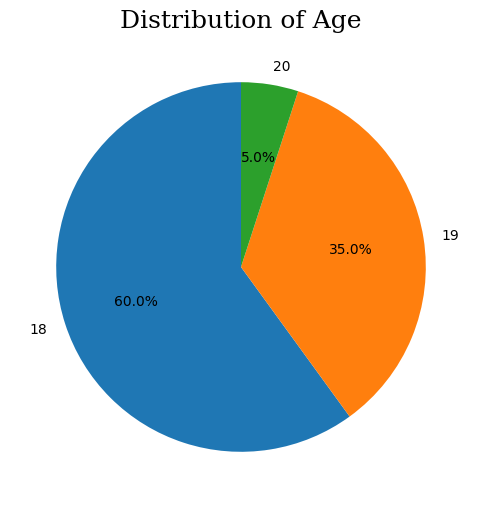

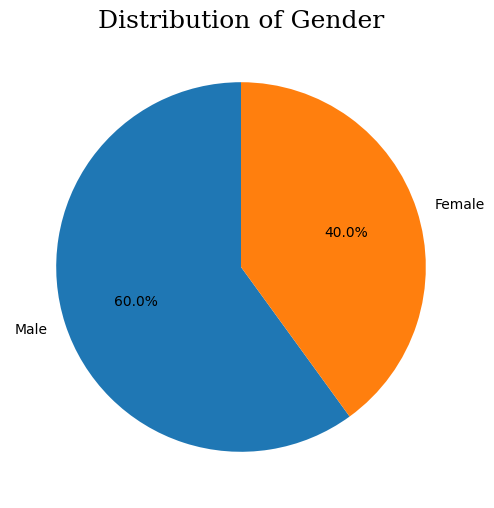

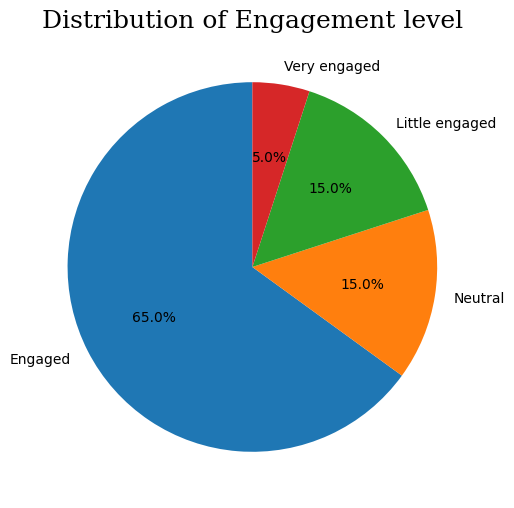

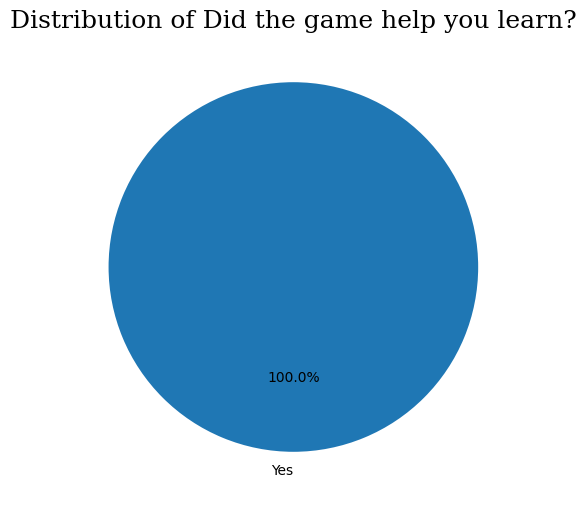

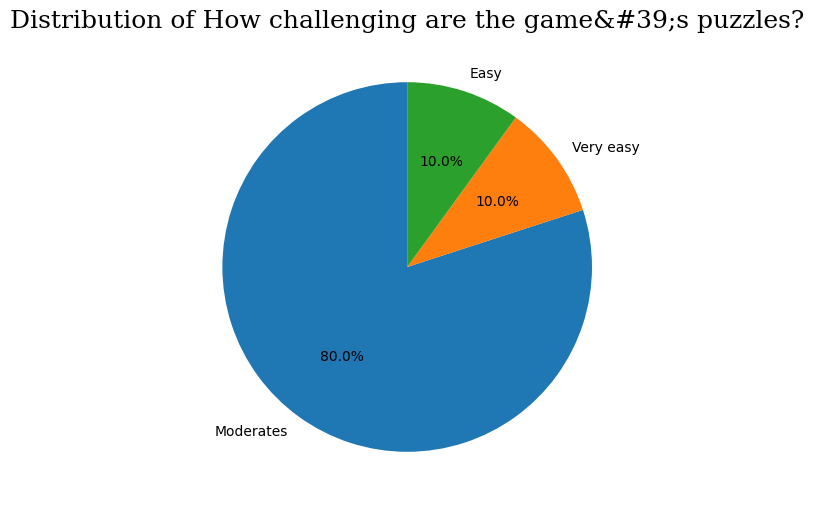

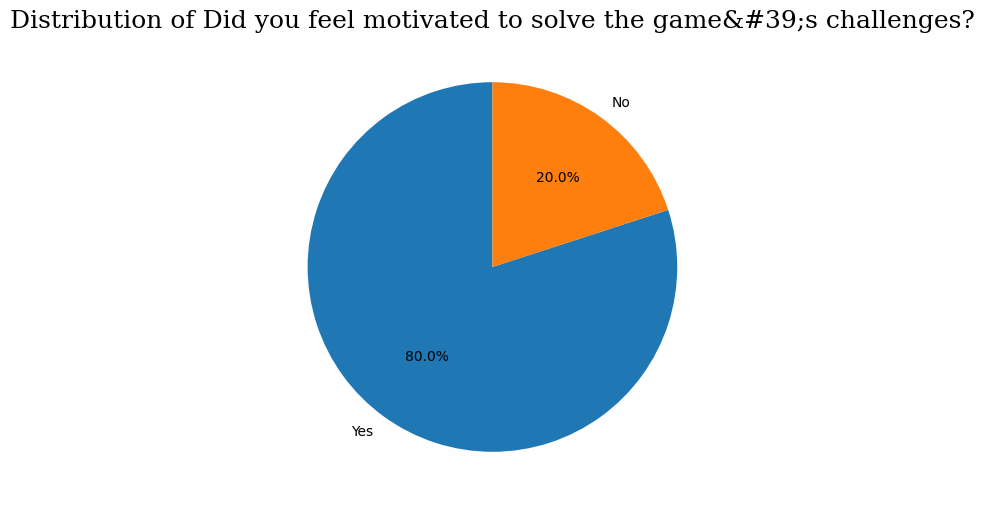

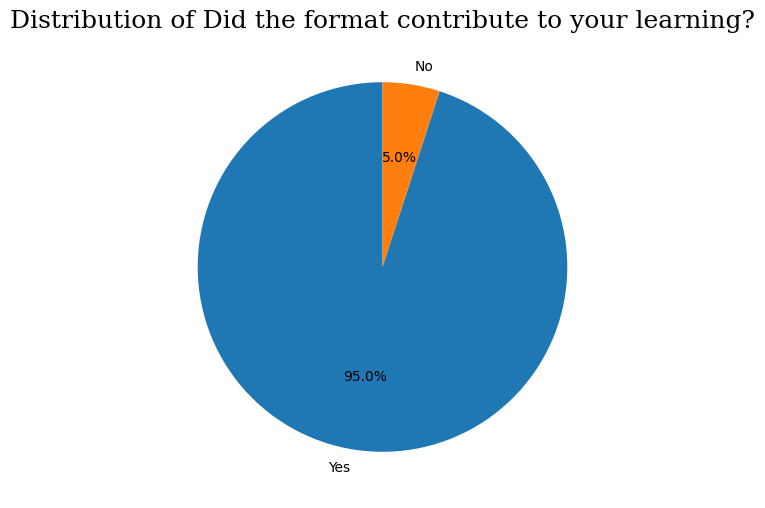

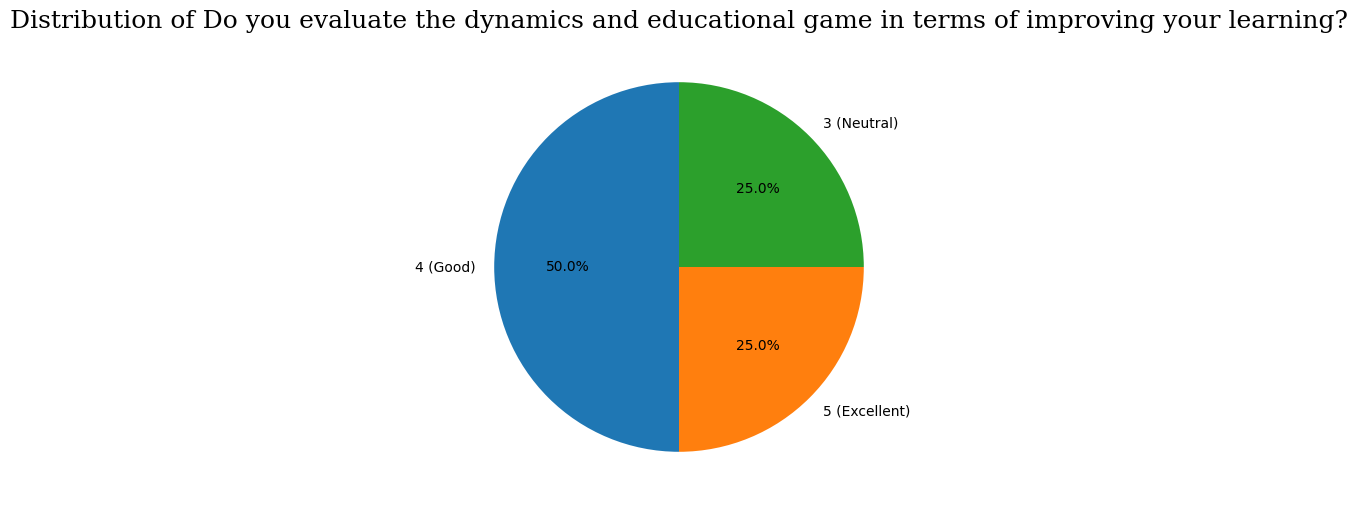

In [46]:
#@title Generates pie charts to visualize the distribution of values for each column in the research DataFrame.

#@markdown This code iterates over each column in the `research_df` DataFrame and generates a pie chart to visualize the distribution of unique values within each column. The value counts for each category are calculated, and then a pie chart is plotted with the percentages of each category.

"""
Generates pie charts to visualize the distribution of values for each column in the research DataFrame.

This code iterates over each column in the `research_df` DataFrame and generates a pie chart
to visualize the distribution of unique values within each column. The value counts for each
category are calculated, and then a pie chart is plotted with the percentages of each category.

Steps:
    1. For each column in the DataFrame, the code calculates the value counts (i.e., the number of
       occurrences of each unique value in the column).
    2. A pie chart is generated using the calculated value counts. The labels of the pie chart correspond
       to the unique values in the column, and the size of each slice represents the percentage of occurrences.
    3. The pie chart is displayed with a title indicating the name of the column being visualized.

Args:
    research_df (pd.DataFrame): The DataFrame containing the research survey data, with each column representing
        a different variable (e.g., age, gender, engagement level, etc.).

Returns:
    None: The function generates and displays a pie chart for each column in the DataFrame.

Example:
    >>> for column in research_df.columns:
    >>>     value_counts = research_df[column].value_counts()
    >>>     plt.figure(figsize=(8, 6))
    >>>     plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    >>>     plt.title(f'Distribution of {column}', fontname='serif', fontsize=18)
    >>>     plt.show()
"""
import matplotlib.pyplot as plt

for column in research_df.columns:
    # Calculate value counts for the column
    value_counts = research_df[column].value_counts()

    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribution of {column}', fontname='serif', fontsize=18)
    plt.show()
